# Exercise 2 - Deep Neural Networks

## Group *ID* : $2207$

### Members

- Pietro Cappelli
    - e-mail: pietro.cappelli@studenti.unipd.it
    - ID: 2058332
- Alberto Coppi
    - e-mail: alberto.coppi@studenti.unipd.it
    - ID: 2053063
- Giacomo Franceschetto
    - e-mail: giacomo.franceschetto@studenti.unipd.it
    - ID: 2053348
- Nicolò Lai
    - e-mail: nicolo.lai@studenti.unipd.it
    - ID: 2064377 
### Author contribution statement

Each and every member of the group equally worked on the assigned project and the drafting of this notebook. 

---

## Import modules and custom libraries

In [1]:
import tensorflow        as tf
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn           as sns

from sklearn.model_selection     import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics             import confusion_matrix

import time
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=UserWarning) 




# ricordiamoci di togliere gli auto-import e di metterli normali
%load_ext autoreload
%autoreload 1
%aimport nn_model
%aimport create_data
%aimport preprocess
%aimport plot_utils
%aimport gridsearch

## 0 - Generate data <a name="first"></a>

Let us first introduce data, namely how we generate it and how we label it. 

We uniformly sample $N=5000$ examples $x \in [-50,\,+50] \times [-50,\,+50] \equiv \mathcal{D}$. Then we apply the following labeling function:

$$
    f(x) = 
    \begin{cases}
    1 & \text{if} & x_1 > -20 \,\land\, x_2 > -40 \,\land\, x_1+x_2 < 40 \\
    0 && \text{otherwise}
    \end{cases}
$$

We show here a figure in which data is plotted and color-coded with its label. On top of that, we also show labeling boundaries (in orange) to better visualize the underlying labeling criterion.

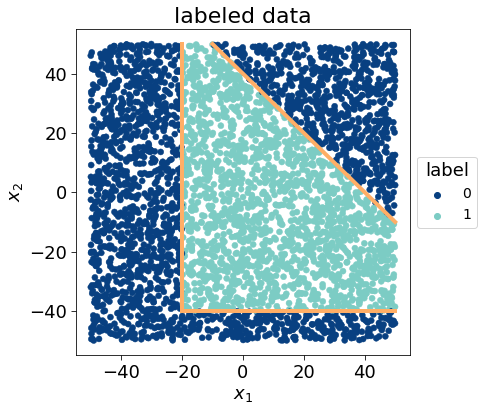

In [2]:
# number of data
N = 4000
# box size
B = 100

# random seed for reproducibility
np.random.seed(20220308)

x, y_true = create_data.create_data(N, B, c="triang")

fig = plt.figure(figsize=(6,6))
ax  = plot_utils.plot_labeled_data(
    x               = x, 
    labels          = y_true, 
    fig             = fig, 
    title           = "labeled data", 
    palette         = "GnBu_r",
    hue_norm        = (0, 2),
    fontsize        = 18, 
    show_boundaries = True
)

plt.show()

## 1 - Study the performance of the DNN when the number N of samples is
### a) reduced
### b) increased 
### c) augmented

### 1a) reduced

In [3]:
#first of all let's define the best model of the NN
n_features = x.shape[1]

# NN hyperparameters
architecture      = [n_features, 20, 20, 1]
dropout_arc       = [1]
dropout_rates     = [0.2]
batch_norm_arc    = [2]   
input_dim         = architecture[0]
hidden_activation = "relu"
output_activation = "sigmoid"
name              = "my lovely neural network"

# build the NN model
network = nn_model.NN(
    input_dim         = input_dim,
    architecture      = architecture,
    dropout_layers    = dropout_arc,
    dropout_rates     = dropout_rates,
    batch_norm_layers = batch_norm_arc,
    hidden_activation = hidden_activation,
    output_activation = output_activation,
    nn_name           = name,
)

# print summary
network.summary()

# compile NN with loss, optimizer and metrics
loss      = "binary_crossentropy"
optimizer = "adam"
metrics   = ["accuracy"]


Model: "my lovely neural network"
____________________________________________________________________________________________________
 Layer (type)                                Output Shape                            Param #        
 input_layer (InputLayer)                    [(None, 2)]                             0              
                                                                                                    
 hidden_0 (Dense)                            (None, 20)                              60             
                                                                                                    
 dropout_0 (Dropout)                         (None, 20)                              0              
                                                                                                    
 batch_norm_1 (BatchNormalization)           (None, 20)                              80             
                                                         

In [5]:
reduction_rates = [1.0, 0.8, 0.6, 0.4, 0.2]
train_frac = 0.7
N = 5000
B = 100

x = create_data.sample_data(N, B)

training_data,   test_data   = [], []
training_labels, test_labels = [], []
x_valid, y_valid = [], []

N_red = [N*rate for rate in reduction_rates]
m_train_red = []

# for tr_rate in reduction_rates:
for N_i in N_red:

    # N = int(N*tr_rate)
    N_train = int(N_i*train_frac)
    N_valid = int(N_train * 0.3) 
    m_train_red.append(N_train)

    permutation = np.random.permutation(N) # random permutation
    x = x[permutation]
    mean = np.mean(x, axis=0) ; std = np.std(x, axis=0)
    x_scaled = preprocess.standardize(x, mean, std)
    
    training_data.append((x_scaled[N_valid:N_train]) )
    training_labels.append( create_data.assign_label(x[N_valid:N_train]) )

    test_data.append((x_scaled[N_train:]) )
    test_labels.append(create_data.assign_label(x[N_train:]) )

    x_valid.append(x_scaled[0:N_valid]) 
    y_valid.append(create_data.assign_label(x[0:N_valid])) 

# print(m_train_red)

#from plot_utils import plot_labeled_data

#for data, labels, rate in zip(training_data, training_labels, reduction_rates):
#    fig = plt.figure(figsize=(7,7))
#    ax = plot_labeled_data(data, labels, fig)
#    plt.show()

In [6]:
#training 

minibatch = 100
N_epochs  = 300

tr_acc_red, val_acc_red = [], []
tr_loss_red, val_loss_red = [], []
test_loss_red, test_acc_red = [], []

for x_tr, y_tr, x_val, y_val, x_test, y_test in zip(training_data, training_labels, x_valid, y_valid, test_data, test_labels):
    network = nn_model.NN(
    input_dim         = input_dim,
    architecture      = architecture,
    dropout_layers    = dropout_arc,
    dropout_rates     = dropout_rates,
    batch_norm_layers = batch_norm_arc,
    hidden_activation = hidden_activation,
    output_activation = output_activation,
    nn_name           = name,
    )

    network.compile(
        loss      = loss,
        optimizer = optimizer,
        metrics   = metrics,
        )


    fit = network.fit(
        x_tr, y_tr,
        epochs          = N_epochs,
        batch_size      = minibatch,
        validation_data = (x_val, y_val),
        verbose         = 0,
    )

    tr_acc_red.append(fit.history['accuracy'])
    val_acc_red.append(fit.history['val_accuracy'])
    tr_loss_red.append(fit.history['loss'])
    val_loss_red.append(fit.history['val_loss'])

    test = network.evaluate(
        x_test, y_test,
        batch_size      = minibatch,
        verbose         = 0,
        )
    test_loss_red.append(test[0])
    test_acc_red.append(test[1])


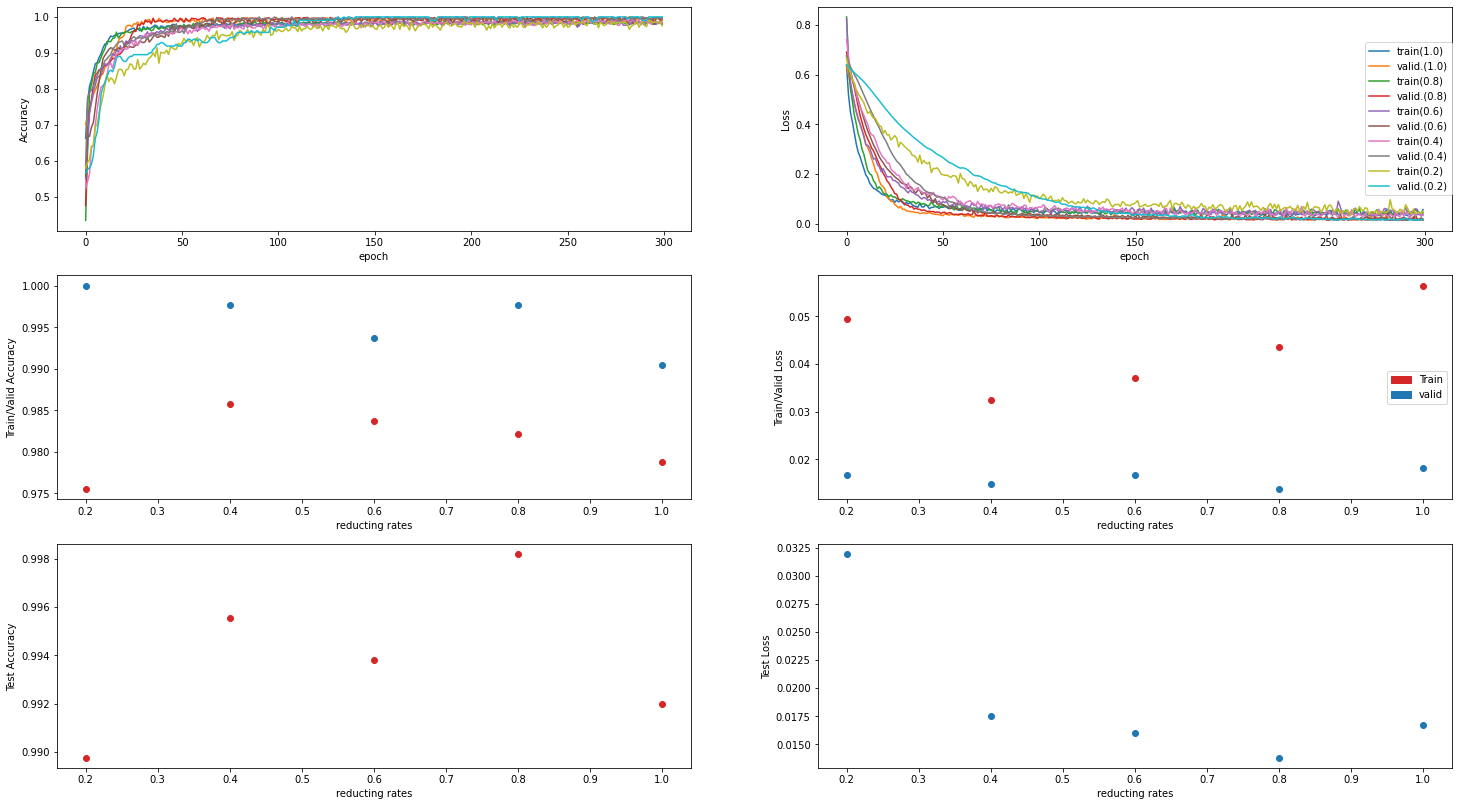

In [75]:
#plotting the results

fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(25,14))
ax[0,0].set_xlabel('epoch'); ax[0,0].set_ylabel("Accuracy")
ax[0,1].set_xlabel('epoch'); ax[0,1].set_ylabel("Loss") 
ax[1,0].set_xlabel('reducting rates'); ax[1,0].set_ylabel("Train/Valid Accuracy")
ax[1,1].set_xlabel('reducting rates'); ax[1,1].set_ylabel("Train/Valid Loss") 
ax[2,0].set_xlabel('reducting rates'); ax[2,0].set_ylabel("Test Accuracy")
ax[2,1].set_xlabel('reducting rates'); ax[2,1].set_ylabel("Test Loss") 

for acc,val, rate in zip(tr_acc_red, val_acc_red, reduction_rates):
    ax[0,0].plot(acc,label="train")
    ax[0,0].plot(val,label="valid.")
    
    ax[1,0].scatter(rate,acc[-1],label="train",color='tab:red')
    ax[1,0].scatter(rate,val[-1],label="valid",color='tab:blue')


for acc,val,rate in zip(tr_loss_red, val_loss_red,reduction_rates):
    ax[0,1].plot(acc,label=f"train({rate})")
    ax[0,1].plot(val,label=f"valid.({rate})")
    
    ax[1,1].scatter(rate,acc[-1],label="train", color='tab:red')
    ax[1,1].scatter(rate,val[-1],label="valid", color='tab:blue')

for acc,val,rate in zip(test_acc_red, test_loss_red, reduction_rates):
    ax[2,0].scatter(rate,acc,label="test_acc", color='tab:red')
    ax[2,1].scatter(rate,val,label="test_loss", color='tab:blue')

ax[0,1].legend(loc='center right',borderaxespad=0)
ax[1,1].legend(loc='center right')

red = mpatches.Patch(color='tab:red', label='Train');blue = mpatches.Patch(color='tab:blue', label='valid')
ax[1,1].legend(handles=[red, blue],loc='center right')

plt.savefig('plots/reduction.pdf')
plt.show()

### 1b) more data

In [25]:
N = 5000
increasing_rates = [1.0, 1.25, 1.50, 1.75, 2.0, 2.5, 3] #ogni volta aggiungo il 25% di N di dati
N_inc = [int(N*i) for i in increasing_rates]

x_training,  x_test = [], []
y_training, y_test = [], []
x_valid, y_valid = [], []
m_train_inc=[]

for N_i in N_inc:
    # N = int(N*rate)
    N_train = int(N_i * train_frac)
    N_valid = int(N_train * 0.3)
    m_train_inc.append(N_train)

    x = create_data.sample_data(N_i, B)
    mean = np.mean(x, axis=0)
    std = np.std(x, axis=0)

    x_scaled = preprocess.standardize(x, mean, std)
    
    x_training.append((x_scaled[N_valid:N_train]) )
    y_training.append( create_data.assign_label(x[N_valid:N_train]) )

    x_test.append((x_scaled[N_train:]) )
    y_test.append(create_data.assign_label(x[N_train:]) )

    x_valid.append(x_scaled[0:N_valid]) 
    y_valid.append(create_data.assign_label(x[0:N_valid])) 

#for data, labels in zip(x_training, y_training):
#    fig = plt.figure(figsize=(7,7))
#    ax = plot_labeled_data(data, labels, fig)
#plt.show()


In [26]:
#training 

minibatch = 100
N_epochs  = 300

tr_acc_inc, val_acc_inc = [], []
tr_loss_inc, val_loss_inc = [], []
test_loss_inc, test_acc_inc = [], []

for x_tr, y_tr, x_val, y_val, x_ts, y_ts in zip(x_training, y_training, x_valid, y_valid, x_test, y_test):

    network = nn_model.NN(
    input_dim         = input_dim,
    architecture      = architecture,
    dropout_layers    = dropout_arc,
    dropout_rates     = dropout_rates,
    batch_norm_layers = batch_norm_arc,
    hidden_activation = hidden_activation,
    output_activation = output_activation,
    nn_name           = name,
    )

    network.compile(
        loss      = loss,
        optimizer = optimizer,
        metrics   = metrics,
        )

    fit = network.fit(
        x_tr, y_tr,
        epochs          = N_epochs,
        batch_size      = minibatch,
        validation_data = (x_val, y_val),
        verbose         = 0,
    )
    #taking only the final value of accuracy and loss
    # tr_acc.append(fit.history['accuracy'][-1])
    # val_acc.append(fit.history['val_accuracy'][-1])
    # tr_loss.append(fit.history['loss'][-1])
    # val_loss.append(fit.history['val_loss'][-1])
    
    tr_acc_inc.append(fit.history['accuracy'])
    val_acc_inc.append(fit.history['val_accuracy'])
    tr_loss_inc.append(fit.history['loss'])
    val_loss_inc.append(fit.history['val_loss'])
    
    test = network.evaluate(
        x_ts, y_ts,
        batch_size      = minibatch,
        verbose         = 0,
        )
    test_loss_inc.append(test[0])
    test_acc_inc.append(test[1])

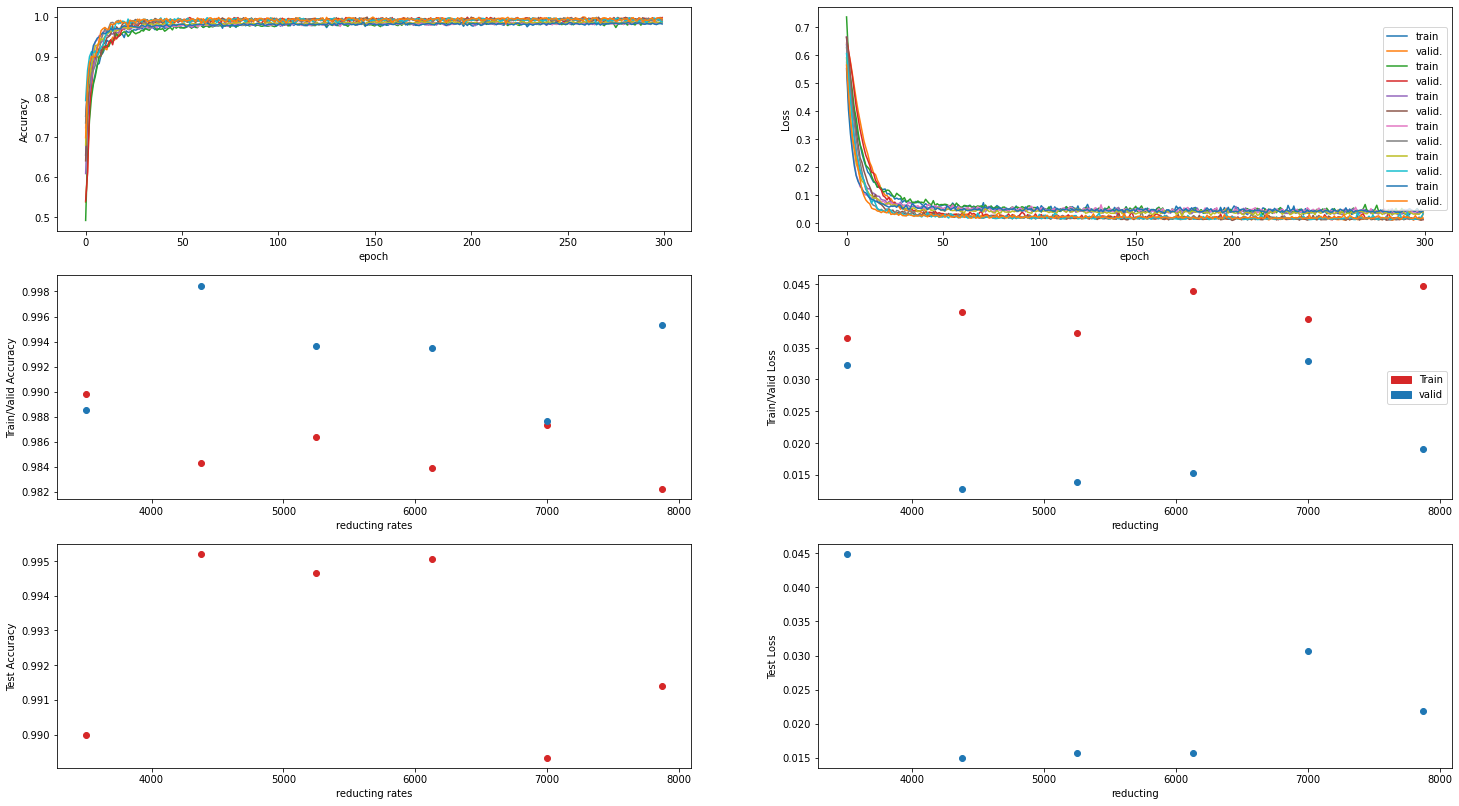

In [79]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(25,14))
ax[0,0].set_xlabel('epoch'); ax[0,0].set_ylabel("Accuracy")
ax[0,1].set_xlabel('epoch'); ax[0,1].set_ylabel("Loss");
ax[1,0].set_xlabel('reducting rates'); ax[1,0].set_ylabel("Train/Valid Accuracy")
ax[1,1].set_xlabel('reducting'); ax[1,1].set_ylabel("Train/Valid Loss") 
ax[2,0].set_xlabel('reducting rates'); ax[2,0].set_ylabel("Test Accuracy")
ax[2,1].set_xlabel('reducting'); ax[2,1].set_ylabel("Test Loss")

for acc,val,dim in zip(tr_acc_inc, val_acc_inc, m_train_inc):
    ax[0,0].plot(acc,label="train")
    ax[0,0].plot(val,label="valid.")
    
    ax[1,0].scatter(dim,acc[-1],label="train",color='tab:red')
    ax[1,0].scatter(dim,val[-1],label="valid",color='tab:blue')


for acc,val,dim in zip(tr_loss_inc, val_loss_inc, m_train_inc):
    ax[0,1].plot(acc,label="train")
    ax[0,1].plot(val,label="valid.")
    
    ax[1,1].scatter(dim,acc[-1],label="train", color='tab:red')
    ax[1,1].scatter(dim,val[-1],label="valid", color='tab:blue')

for acc,val,dim in zip(test_acc_inc, test_loss_inc,(m_train_inc)):
    ax[2,0].scatter(dim,acc,label="test_acc", color='tab:red')
    ax[2,1].scatter(dim,val,label="test_loss", color='tab:blue')

ax[0,1].legend(loc='center right')
# ax[1,1].legend(loc='lower right')
red = mpatches.Patch(color='tab:red', label='Train');blue = mpatches.Patch(color='tab:blue', label='valid')
ax[1,1].legend(handles=[red, blue],loc='center right')

plt.savefig('plots/increase.pdf')
plt.show()

### 1c) augmented

First of all we define a function that takes in input an array of data and returns the simulate data by translating the data in input. The components of the translation vector are random values between -5 and 5 (the translation is done before the rescaled procedure)

In [31]:
def traslate(x):
    trasl_data = []
    for dat in x:
        v = np.array( (np.random.random(2)-0.5)*20 ) # vettore traslazione
        trasl_data.append( dat + v )
    return trasl_data

In [32]:
N=5000
m_i = int(0.25 * N)

X = create_data.sample_data(N, B)
mean = np.mean(X, axis=0) ; std = np.std(X, axis=0)
X_scaled = preprocess.standardize(X, mean, std)

X_training,  X_test = [], []
Y_training, Y_test = [], []
X_valid, Y_valid = [], []
m_train_sim = []

dati=X

for i in range(4):
    first, last = i*m_i , (i+1)*m_i
    trs_list = np.array(traslate(X[first:last]))
    dati = np.append(dati, trs_list, axis=0) 


for i in range(5):
    dim = N + i*m_i

    X = dati[0:dim]
    perm = np.random.permutation(dim); X = X[perm] #random permutation
    
    mean = np.mean(X, axis=0) ; std = np.std(X, axis=0)
    X_scaled = preprocess.standardize(X, mean, std)

    # N = len(X)
    N_train = int(dim*train_frac)
    N_valid = int(N_train*0.3)
    m_train_sim.append(N_train)
   
    X_training.append((X_scaled[N_valid:N_train]) )
    Y_training.append( create_data.assign_label(X[N_valid:N_train]) )

    X_test.append((X_scaled[N_train:]) )
    Y_test.append(create_data.assign_label(X[N_train:]) )

    X_valid.append(X_scaled[0:N_valid]) 
    Y_valid.append(create_data.assign_label(X[0:N_valid])) 

    # print(f'la dim totale: {dim}')
    # print(f'training size {len(X_training[i])}, {len(Y_training[i])}')
    # print(f'val {len(X_valid[i])},{len(Y_valid[i])}')
    # print(f'test {len(X_test[i])},{len(Y_test[i])}')

# print(m_train_sim)



In [33]:
tr_acc_sim, val_acc_sim = [], []
tr_loss_sim, val_loss_sim = [], []
test_loss_sim, test_acc_sim = [], []

for x_tr, y_tr, x_val, y_val, x_ts, y_ts in zip(X_training, Y_training, X_valid, Y_valid, X_test, Y_test):

    network = nn_model.NN(
    input_dim         = input_dim,
    architecture      = architecture,
    dropout_layers    = dropout_arc,
    dropout_rates     = dropout_rates,
    batch_norm_layers = batch_norm_arc,
    hidden_activation = hidden_activation,
    output_activation = output_activation,
    nn_name           = name,
    )

    network.compile(
        loss      = loss,
        optimizer = optimizer,
        metrics   = metrics,
        )

    fit = network.fit(
        x_tr, y_tr,
        epochs          = N_epochs,
        batch_size      = minibatch,
        validation_data = (x_val, y_val),
        verbose         = 0,
    )
    
    tr_acc_sim.append(fit.history['accuracy'])
    val_acc_sim.append(fit.history['val_accuracy'])
    tr_loss_sim.append(fit.history['loss'])
    val_loss_sim.append(fit.history['val_loss'])
    
    test = network.evaluate(
        x_ts, y_ts,
        batch_size      = minibatch,
        verbose         = 0,
        )
    test_loss_sim.append(test[0])
    test_acc_sim.append(test[1])

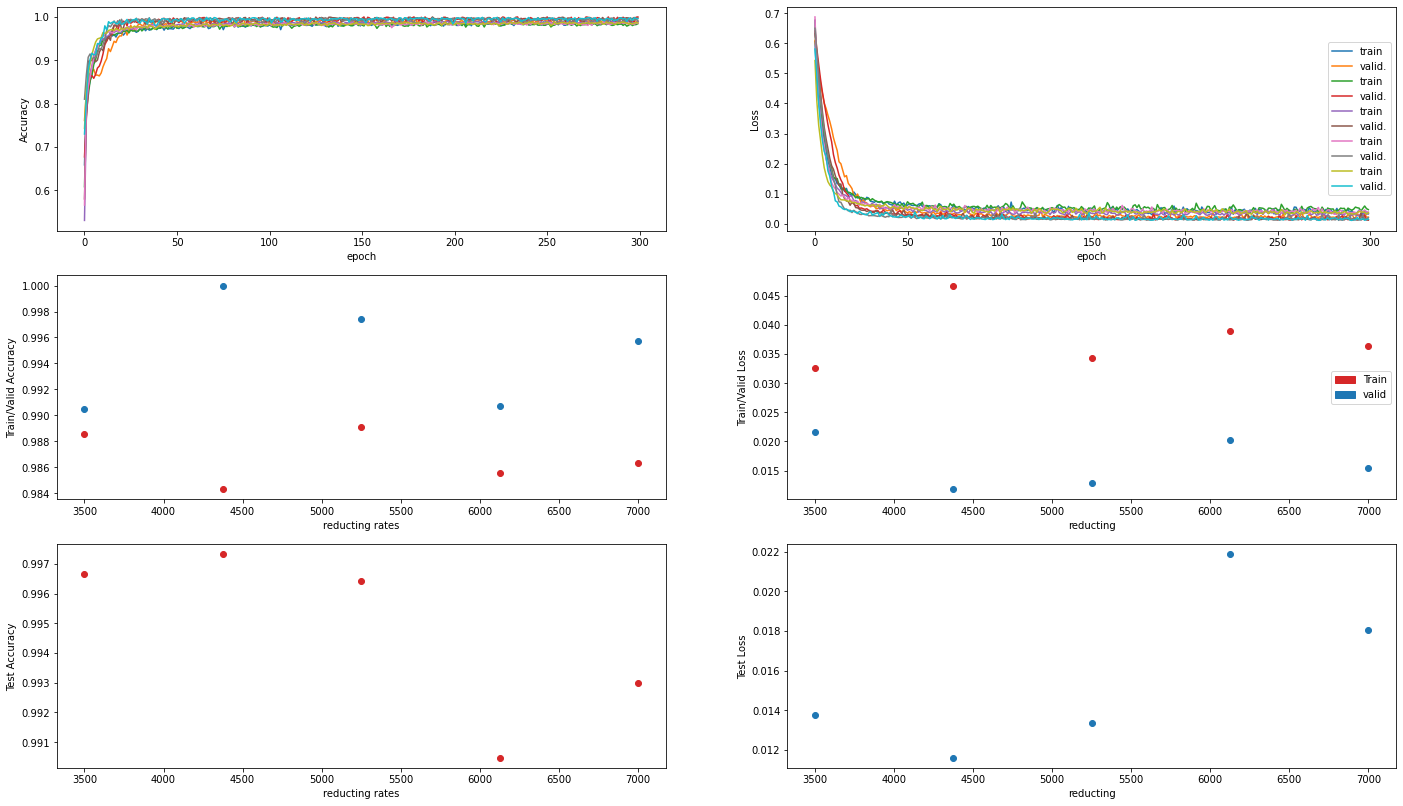

In [81]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(24,14))
ax[0,0].set_xlabel('epoch'); ax[0,0].set_ylabel("Accuracy")
ax[0,1].set_xlabel('epoch'); ax[0,1].set_ylabel("Loss"); 
ax[1,0].set_xlabel('reducting rates'); ax[1,0].set_ylabel("Train/Valid Accuracy")
ax[1,1].set_xlabel('reducting'); ax[1,1].set_ylabel("Train/Valid Loss") 
ax[2,0].set_xlabel('reducting rates'); ax[2,0].set_ylabel("Test Accuracy")
ax[2,1].set_xlabel('reducting'); ax[2,1].set_ylabel("Test Loss")

for acc,val,m in zip(tr_acc_sim, val_acc_sim, m_train_sim):
    ax[0,0].plot(acc,label="train")
    ax[0,0].plot(val,label="valid.")
    
    ax[1,0].scatter(m,acc[-1],label="train",color='tab:red')
    ax[1,0].scatter(m,val[-1],label="valid",color='tab:blue')


for acc,val,m in zip(tr_loss_sim, val_loss_sim, m_train_sim):
    ax[0,1].plot(acc,label="train")
    ax[0,1].plot(val,label="valid.")
    
    ax[1,1].scatter(m,acc[-1],label="train", color='tab:red')
    ax[1,1].scatter(m,val[-1],label="valid", color='tab:blue')

for acc,val,rate in zip(test_acc_sim, test_loss_sim, m_train_sim):
    ax[2,0].scatter(rate,acc,label="test_acc", color='tab:red')
    ax[2,1].scatter(rate,val,label="test_loss", color='tab:blue')

ax[0,1].legend(loc='center right')
# ax[1,1].legend(loc='lower right')
red = mpatches.Patch(color='tab:red', label='Train');blue = mpatches.Patch(color='tab:blue', label='valid')
ax[1,1].legend(handles=[red, blue],loc='center right')

plt.savefig('plots/simulate.pdf')
plt.show()

### Results

In [ ]:
#cose da calcolare: a che numero di epoche satura e poi prendo la deviazione standard e metti le barre di errore




In [175]:
#red
red_train_accuracy = [np.mean(tr[-100:]) for tr in tr_acc_red ]
red_valid_accuracy = [np.mean(tr[-100:]) for tr in val_acc_red]
red_train_acc_std = np.std(tr_acc_red[-100:])/np.sqrt(100)
red_valid_acc_std = np.std(val_acc_red[-100:])/np.sqrt(100)

red_train_loss = [np.mean(tr[-100:]) for tr in tr_loss_red]
red_valid_loss = [np.mean(tr[-100:]) for tr in val_loss_red]
red_train_loss_std = np.std(tr_loss_red[-100:])/np.sqrt(100)
red_valid_loss_std = np.std(val_loss_red[-100:])/np.sqrt(100)

#inc
inc_train_accuracy = [np.mean(tr[-100:]) for tr in tr_acc_inc ]
inc_valid_accuracy = [np.mean(tr[-100:]) for tr in val_acc_inc]
inc_train_acc_std = np.std(tr_acc_sim[-100:])/np.sqrt(100)
inc_valid_acc_std = np.std(val_acc_sim[-100:])/np.sqrt(100)

inc_train_loss = [np.mean(tr[-100:]) for tr in tr_loss_inc]
inc_valid_loss = [np.mean(tr[-100:]) for tr in val_loss_inc]
inc_train_loss_std = np.std(tr_loss_sim[-100:])/np.sqrt(100)
inc_valid_loss_std = np.std(val_loss_sim[-100:])/np.sqrt(100)

# sim
sim_train_accuracy = [np.mean(tr[-100:]) for tr in tr_acc_sim ]
sim_valid_accuracy = [np.mean(tr[-100:]) for tr in val_acc_sim]
sim_train_acc_std = np.std(tr_acc_sim[-100:])/np.sqrt(100)
sim_valid_acc_std = np.std(val_acc_sim[-100:])/np.sqrt(100)

sim_train_loss = [np.mean(tr[-100:]) for tr in tr_loss_sim]
sim_valid_loss = [np.mean(tr[-100:]) for tr in val_loss_sim]
sim_train_loss_std = np.std(tr_loss_sim[-100:])/np.sqrt(100)
sim_valid_loss_std = np.std(val_loss_sim[-100:])/np.sqrt(100)

print(red_train_acc_std)
print(red_train_accuracy)

0.00516437382585109
[0.9842326492071152, 0.9835306090116501, 0.9838095200061798, 0.984755100607872, 0.9797346901893615]


IndexError: invalid index to scalar variable.

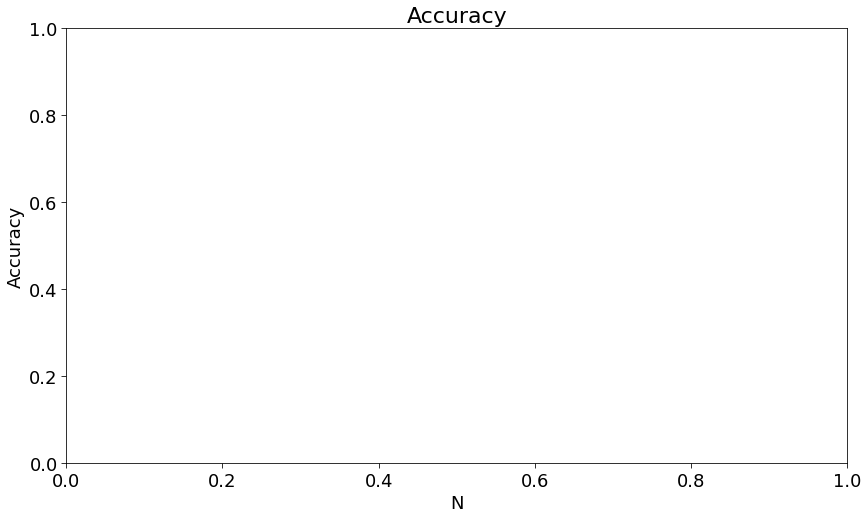

In [226]:
fig, ax = plt.subplots(figsize=(14,8))
ax.set_title('Accuracy', fontsize=22)


ax.set_xlabel('N', fontsize=18); ax.set_ylabel("Accuracy", fontsize=18)

ax.tick_params(axis="both", which="major", labelsize=18, length=5)


## reduction
ax.errorbar(
    x          = N_red + N_inc[1:],
    y          = red_train_accuracy+inc_train_accuracy[1:],
    yerr       = red_train_acc_std+inc_train_acc_std[1:],
    linestyle  = "solid",
    linewidth  = 2,
    elinewidth = 2, 
    capsize    = 2, 
    marker     = "o",
    color      = "#009cff",
    label      = "train"
)

ax.errorbar(
    x          = N_red,
    y          = red_valid_accuracy,
    yerr       = red_valid_acc_std,
    linestyle  = "solid",
    linewidth  = 2,
    elinewidth = 2, 
    capsize    = 2, 
    marker     = "o",
    color      = "#db3444",
    label      = "val"
)

ax.plot(
    N_red,
    test_acc_red,
    linestyle  = "dashed",
    linewidth  = 7,
    alpha      = 0.5,
    marker     = None,
    color      = "#44db34",
    label      = "test",
    zorder     = 10
)


# increased
# ax.errorbar(
#     x          = N_inc,
#     y          = inc_train_accuracy,
#     yerr       = inc_train_acc_std,
#     linestyle  = "solid",
#     linewidth  = 2,
#     elinewidth = 2, 
#     capsize    = 2, 
#     marker     = "o",
#     color      = "#009cff",
#     label      = "train"
# )
# 
# ax.errorbar(
#     x          = N_inc,
#     y          = inc_valid_accuracy,
#     yerr       = inc_valid_acc_std,
#     linestyle  = "solid",
#     linewidth  = 2,
#     elinewidth = 2, 
#     capsize    = 2, 
#     marker     = "o",
#     color      = "#db3444",
#     label      = "val"
# )
# 
# ax.plot(
#     N_inc,
#     test_acc_inc,
#     linestyle  = "dashed",
#     linewidth  = 7,
#     alpha      = 0.5,
#     marker     = None,
#     color      = "#44db34",
#     label      = "test",
#     zorder     = 10
# )



fig, ax = plt.subplots(figsize=(14,8))
ax.set_title('Loss', fontsize=22)

ax.set_xlabel('N', fontsize=18); ax.set_ylabel("Loss", fontsize=18)
ax.tick_params(axis="both", which="major", labelsize=18, length=5)




ax.errorbar(
    x          = N_red,
    y          = red_train_loss,
    yerr       = red_train_loss_std,
    linestyle  = "solid",
    linewidth  = 2,
    elinewidth = 2, 
    capsize    = 2, 
    marker     = "o",
    color      = "#009cff",
    label      = "train"
)

ax.errorbar(
    x          = N_red,
    y          = red_valid_loss,
    yerr       = red_valid_loss_std,
    linestyle  = "solid",
    linewidth  = 2,
    elinewidth = 2, 
    capsize    = 2, 
    marker     = "o",
    color      = "#db3444",
    label      = "val"
)

ax.plot(
    N_red,
    test_loss_red,
    linestyle  = "dashed",
    linewidth  = 7,
    alpha      = 0.5,
    marker     = None,
    color      = "#44db34",
    label      = "test",
    zorder     = 10
)

ax.errorbar(
    x          = N_inc,
    y          = inc_train_loss,
    yerr       = inc_train_loss_std,
    linestyle  = "solid",
    linewidth  = 2,
    elinewidth = 2, 
    capsize    = 2, 
    marker     = "o",
    color      = "#009cff",
    label      = "train"
)

ax.errorbar(
    x          = N_inc,
    y          = inc_valid_loss,
    yerr       = inc_valid_loss_std,
    linestyle  = "solid",
    linewidth  = 2,
    elinewidth = 2, 
    capsize    = 2, 
    marker     = "o",
    color      = "#db3444",
    label      = "val"
)

ax.plot(
    N_inc,
    test_loss_inc,
    linestyle  = "dashed",
    linewidth  = 7,
    alpha      = 0.5,
    marker     = None,
    color      = "#44db34",
    label      = "test",
    zorder     = 10
)
        
# reducted
# ax[0].plot(N_red, red_train_accuracy, lw=2, ls="-", color='#009cff')
# ax[0].errorbar(N_red, red_train_accuracy, yerr=red_train_acc_std, color='#009cff')
# ax[0].plot(N_red, red_valid_accuracy , lw=2, ls="-", marker="o",label="valid",color='#db3444')
# ax[0].errorbar(N_red, red_valid_accuracy, yerr=red_valid_acc_std,color='#db3444')
# ax[0].plot(N_red, test_acc_red, lw=2, ls="-", marker="o" ,label="test",color='#44db34')
# 
# ax[1].plot(N_red, red_train_loss, lw=2, ls="-", marker="o",label="train",color='#009cff')
# ax[1].errorbar(N_red, red_train_loss, yerr=red_train_acc_std,color='#009cff')
# ax[1].plot(N_red, red_valid_loss , lw=2, ls="-", marker="o",label="valid",color='#db3444')
# ax[1].errorbar(N_red, red_valid_loss, yerr=red_train_loss_std,color='#db3444')
# ax[1].plot(N_red, test_loss_red, lw=2, ls="-", marker="o" ,label="test",color='#44db34')
# 
# # increased
# ax[0].plot(N_inc, inc_train_accuracy, lw=2, ls="-", marker="o",color='#009cff')
# ax[0].errorbar(N_inc, inc_train_accuracy, yerr=inc_train_acc_std,color='#009cff')
# ax[0].plot(N_inc, inc_valid_accuracy , lw=2, ls="-", marker="o",color='#db3444')
# ax[0].errorbar(N_inc, inc_valid_accuracy, yerr=inc_valid_acc_std,color='#db3444')
# ax[0].plot(N_inc, test_acc_inc, lw=2, ls="-", marker="o" ,color='#44db34')
# 
# ax[1].plot(N_inc, inc_train_loss, lw=2, ls="-", marker="o",color='#009cff')
# ax[1].errorbar(N_inc, inc_train_loss, yerr=inc_train_loss_std,color='#009cff')
# ax[1].plot(N_inc, inc_valid_loss , lw=2, ls="-", marker="o",color='#db3444')
# ax[1].errorbar(N_inc, inc_valid_loss, yerr=inc_valid_loss_std,color='#db3444')
# ax[1].plot(N_inc, test_loss_inc, lw=2, ls="-", marker="o" ,color='#44db34')
# 
# ax[0].legend(bbox_to_anchor =(1, 1))
# ax[1].legend(bbox_to_anchor =(1, 1))

# plt.savefig('plots/increased_reducted.pdf')
plt.show()

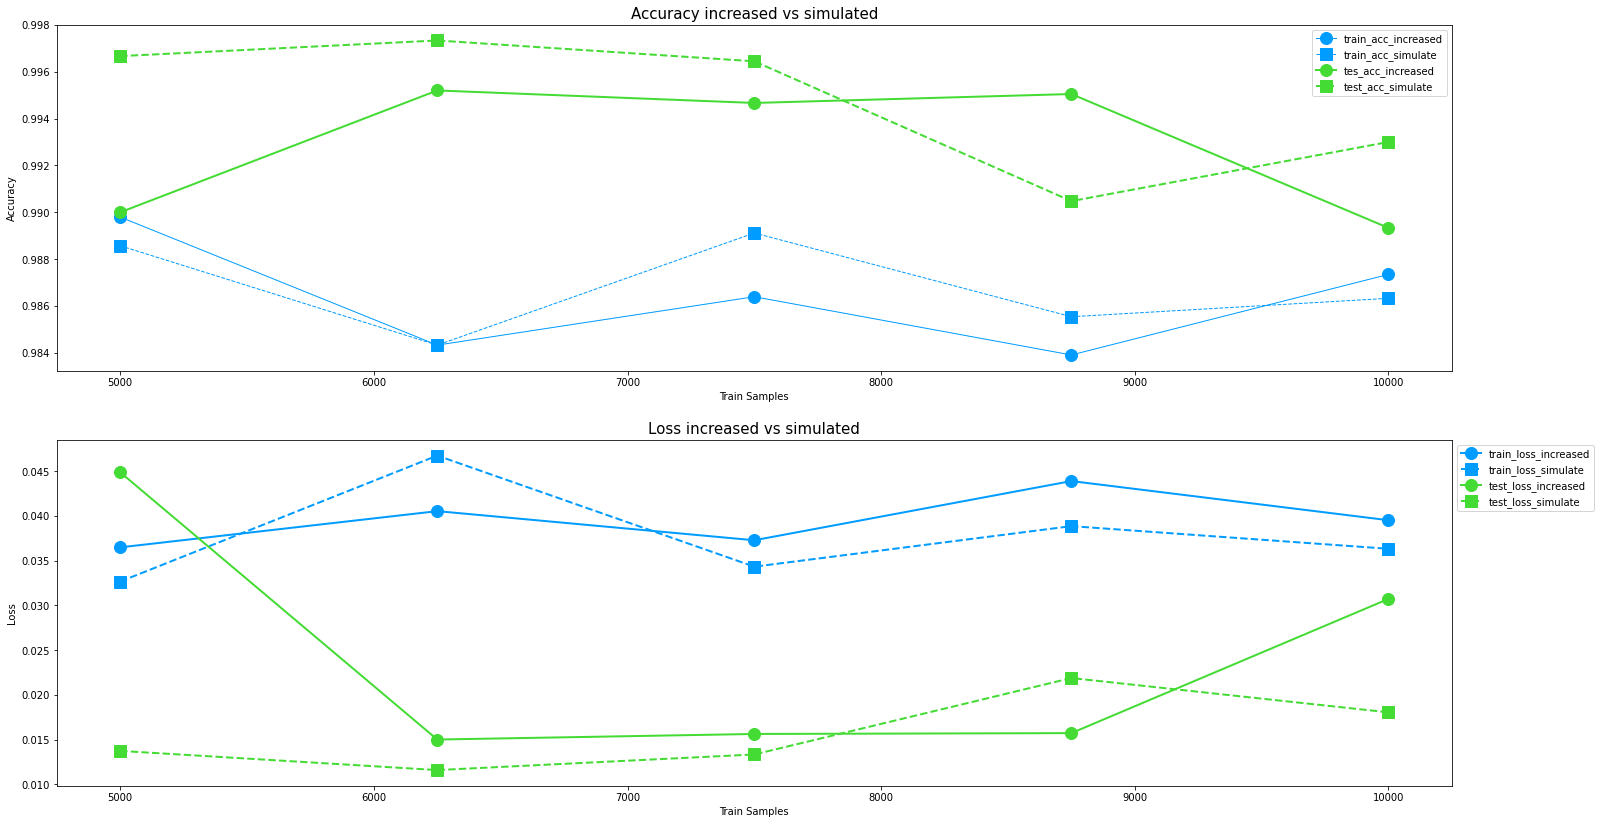

In [157]:
# accuracy increased vs simulated
fig, ax = plt.subplots(figsize=(25,14), nrows=2)
ax[0].set_title('Accuracy increased vs simulated',fontsize=15)
ax[1].set_title('Loss increased vs simulated',fontsize=15)

a = np.concatenate((np.expand_dims(N_inc[:5],1), np.expand_dims(inc_train_accuracy[:-1],1)), axis=1)
b = np.concatenate((np.expand_dims(N_inc[:5],1), np.expand_dims(sim_train_accuracy,1)), axis=1)

ax[0].plot(a[:,0],a[:,1], lw=2, ls="-", marker="o", markersize=12, label="train_acc_increased", color="#009cff")
ax[0].plot(b[:,0],b[:,1], lw=2, ls="--", marker="s", markersize=12, label="train_acc_simulate", color="#009cff")

# ax[0].plot(N_inc[:5], inc_valid_accuracy[:5], lw=2, ls="-", marker="o", markersize=12, label="valid_acc_increased", color="#db3444" )
# ax[0].plot(N_inc[:5], sim_valid_accuracy , lw=2, ls="--", marker="s", markersize=12, label="valid_acc_simulate", color="#db3444")

ax[0].plot(N_inc[:5], test_acc_inc[:5], lw=2, ls="-", marker="o", markersize=12, label="tes_acc_increased", color="#44db34" )
ax[0].plot(N_inc[:5], test_acc_sim , lw=2, ls="--", marker="s", markersize=12, label="test_acc_simulate", color="#44db34")

ax[0].set_xlabel('Train Samples'); ax[0].set_ylabel('Accuracy'); ax[0].legend(bbox_to_anchor =(1, 1))

#loss
ax[1].plot(N_inc[:5], inc_train_loss[:5], lw=2, ls="-", marker="o", markersize=12, label="train_loss_increased", color="#009cff" )
ax[1].plot(N_inc[:5], sim_train_loss , lw=2, ls="--", marker="s", markersize=12, label="train_loss_simulate", color="#009cff")

# ax[1].plot(N_inc[:5], inc_valid_loss[:5], lw=2, ls="-", marker="o", markersize=12, label="valid_loss_increased", color="#db3444" )
# ax[1].plot(N_inc[:5], sim_valid_loss , lw=2, ls="--", marker="s", markersize=12, label="valid_loss_simulate", color="#db3444")

ax[1].plot(N_inc[:5], test_loss_inc[:5], lw=2, ls="-", marker="o", markersize=12, label="test_loss_increased", color="#44db34" )
ax[1].plot(N_inc[:5], test_loss_sim , lw=2, ls="--", marker="s", markersize=12, label="test_loss_simulate", color="#44db34")

ax[1].set_xlabel('Train Samples'); ax[1].set_ylabel('Loss'); ax[1].legend(bbox_to_anchor =(1, 1))

plt.savefig("plots/Accuracy_inc_sim.pdf")
plt.show()



## 2 - Implement a “grid search” to improve one or more of the aspects or parameters of the model

### Preparing data

In [ ]:
# number of data
N = 4000
# box size
B = 100

# random seed for reproducibility
np.random.seed(20220308)

x, y_true = create_data.create_data(N, B, c="triang")

In [ ]:
## RE SCALING DATA
mean = np.mean(x, axis=0)
std = np.std(x, axis=0)

x_scaled = preprocess.standardize(x, mean, std)

## SPLIT TRAIN  VALID AND TEST -> da vedere se mettere univoco all'inizio o cosa
train_test_frac  = 0.7
valid_train_frac = 0.2 

N_train = int(N*train_test_frac*(1-valid_train_frac))
N_valid = int(N*train_test_frac*valid_train_frac)
N_test  = int(N*(1-train_test_frac))

train_idx = N_train
valid_idx = N_train + N_valid
test_idx  = N_train + N_valid + N_test

x_train, y_train = np.copy(x_scaled[:train_idx]),  np.copy(y_true[:train_idx])
x_valid, y_valid = np.copy(x_scaled[train_idx:valid_idx]), np.copy(y_true[train_idx:valid_idx])
x_test,  y_test  = np.copy(x_scaled[valid_idx:test_idx]), np.copy(y_true[valid_idx:test_idx])

print(f"\nN_train :\t{x_train.shape[0]} \nN_valid :\t{x_valid.shape[0]} \nN_test :\t{x_test.shape[0]}")


N_train :	2240 
N_valid :	560 
N_test :	1200


### Define NN and its architecture

In [116]:
def create_model(
    n_features,
    neurons           = [20, 20, 1],
    dropout_arc       = [1],
    dropout_rates     = [0.2],
    hidden_activation = "relu",
    batch_norm_arc    = None,
    output_activation = "sigmoid",
    name              = "my lovely neural network",
    loss              = "binary_crossentropy",
    optimizer         = "adam",
    metrics           = ["accuracy"]
):
    # initialize architecture
    architecture = [n_features] + neurons
    input_dim    = n_features

    # create model
    network = nn_model.NN(
        input_dim         = input_dim,
        architecture      = architecture,
        dropout_layers    = dropout_arc,
        dropout_rates     = dropout_rates,
        batch_norm_layers = batch_norm_arc,
        hidden_activation = hidden_activation,
        output_activation = output_activation,
        nn_name           = name
    ) 

    # solves the "Model cannot be saved" issue
    network.compute_output_shape((None, input_dim))   
    
    network.compile(
        loss      = loss,
        optimizer = optimizer,
        metrics   = metrics,
    )
    return network

In [117]:
minibatch = 50
N_epochs  = 250
model_gridsearch = KerasClassifier(build_fn=create_model, 
                                   n_features=x.shape[1], 
                                   epochs=N_epochs, 
                                   batch_size=minibatch)

### Initial guess performances

Here we look at the performances of the DNN implemented without optimizing its hyperparameters but setting them with a guess based on initial considerations:
- *neurons*          : [20, 20, 1]
- *dropout_arc*      : [1]
- *dropout_rate*     : [0.2]
- *hidden_activation*: relu
- *output_activation*: sigmoid
- *loss*             : binary_crossentropy
- *optimizer*        : adam
- *metrics*          : [accuracy]

In [ ]:
# check current model
model_gridsearch.get_params()

{'n_features': 2,
 'epochs': 250,
 'batch_size': 50,
 'build_fn': <function __main__.create_model(n_features, neurons=[20, 20, 1], dropout_arc=[1], dropout_rates=[0.2], hidden_activation='relu', batch_norm_arc=None, output_activation='sigmoid', name='my lovely neural network', loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])>}

In [ ]:
# fit initial model
fit = model_gridsearch.fit(x_train, y_train, validation_data=(x_valid, y_valid), verbose=0)

# compute predictions
y_pred =model_gridsearch.predict(x_test)

pred_binary = y_pred.copy()
pred_binary[y_pred <= 0.5] = 0
pred_binary[y_pred >  0.5] = 1

# compute confusion matrix
cm = confusion_matrix(y_test, plot_utils.flatten(pred_binary))

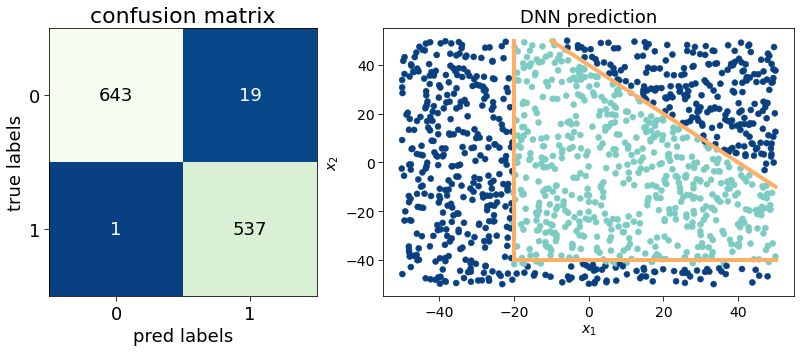

In [ ]:
fig = plt.figure(figsize=(12,5), constrained_layout=True)

# plot confusion matrix
ax = fig.add_subplot(121)

plot_utils.plot_confusion_matrix(
    cm = cm,
    ax = ax,
    title = "confusion matrix"
)
# plot predictions

# scale back x data
#mean = np.mean(x, axis=0)
#std = np.std(x, axis=0)

ax  = plot_utils.plot_labeled_data(
        x               = x_test*std + mean, 
        labels          = plot_utils.flatten(y_pred), 
        fig             = fig, 
        subplot_id      = 122,
        title           = "DNN prediction", 
        palette         = "GnBu_r",
        hue_norm        = (0, 2),
        fontsize        = 14, 
        legend          = False 
    )
plot_utils.boundaries(ax)
    
plt.show()

In [ ]:
# sensitivity
true_positive  = cm[1,1]
false_postive  = cm[0,1]
true_negative  = cm[0,0]
false_negative = cm[1,0]

sensitivity    = true_positive/(true_positive+false_negative)
specificity    = true_negative/(true_negative+false_postive)

print(r"sensitivity = %.2f%%"%(sensitivity*100))
print(r"specificity = %.2f%%"%(specificity*100))

sensitivity = 99.81%
specificity = 97.13%


### Grid Search CV

We now implement a grid search in order to tune the network hyperparameters. Optimization is performed splitting the hyperparameter space in two clusters:

1. optimizer, loss, hidden activation function, epochs, batch size 
2. shape of the network & number of total neurons, dropout architecture, dropout rates

the former includes the main learning parameters and the latter takes care of the NN architecture. Dropout settings are grouped with the second cluster given their close dependence with the NN architecture.

Then, for each cluster we proceed as follow:

- perform a grid search over each single parameter of the cluster, refine the default model with the best found value
- taking into accounts the values within a $\sigma$ of the best value for each parameter re-run a grid search for all the parameters of the given cluster, re-fine the model with the new best values


To perfrom grid search operations we used the `GridSearchCV` method from the *sklearn* library, and for a more user-friendly usage the interface with this method is handled by the `GridSearch` class implemented in ```gridsearch.py```.


#### 1 - Learning parameters
Below, we reported all the different values that we explored for each parameter, a more in-depth description of the roles and differences between the various possibilities can be found [here](https://keras.io/api/).
$$
\textit{optimizer}=
\begin{cases}
\text{SGD} \\
\text{RMSprop} \\
\text{Adam} \\
\text{Adadelta} \\
\text{Adagrad} \\
\text{Nadam} \\
\text{Adamax} \\
\text{Ftrl} 
\end{cases}
\hspace{0.5 cm}
\textit{hidden activation}=
\begin{cases}
\text{relu} \\
\text{elu} \\
\text{sigmoid} \\
\text{tanh} \\
\text{softmax} \\
\text{softsign} \\
\text{softplus} \\
\text{selu} 
\end{cases}
\hspace{0.5 cm}
\textit{loss}=
\begin{cases}
\text{binary\_crossentropy} \\
\text{hinge} \\
\text{squared\_hinge} 
\end{cases}
\hspace{0.5 cm}
\textit{epochs}=
\begin{cases}
10 \\
50 \\
100 \\
200 \\
300 \\
400 \\ 
\end{cases}
\hspace{0.5 cm}
\textit{batch size}=
\begin{cases}
50 \\
100 \\
250 \\
500 \\
1000 \\
\text{N\_train} \\ 
\end{cases}
$$

In [ ]:
## OPTIMIZER
# define parameter list
optimizer  = ['SGD', 'RMSprop', 'Adam', 'Adadelta', 'Adagrad', 'Nadam', 'Adamax', 'Ftrl']
param_grid = dict(optimizer = optimizer)

# perform grid search
grid = gridsearch.GridSearch(x_train, y_train, model_gridsearch, param_grid)
grid.get_result()

GridSearchCV(cv=4,
             estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7f871a3adb50>,
             n_jobs=-1,
             param_grid={'optimizer': ['SGD', 'RMSprop', 'Adam', 'Adadelta',
                                       'Adagrad', 'Nadam', 'Adamax', 'Ftrl']})

Best: 0.998661 using {'optimizer': 'Nadam'}
0.998661 (0.000773) with: {'optimizer': 'Nadam'}
0.995982 (0.001946) with: {'optimizer': 'Adam'}
0.995536 (0.001996) with: {'optimizer': 'RMSprop'}
0.994643 (0.002187) with: {'optimizer': 'Adamax'}
0.983482 (0.005110) with: {'optimizer': 'SGD'}
0.741518 (0.014025) with: {'optimizer': 'Adagrad'}
0.547768 (0.017005) with: {'optimizer': 'Ftrl'}
0.515625 (0.118426) with: {'optimizer': 'Adadelta'}


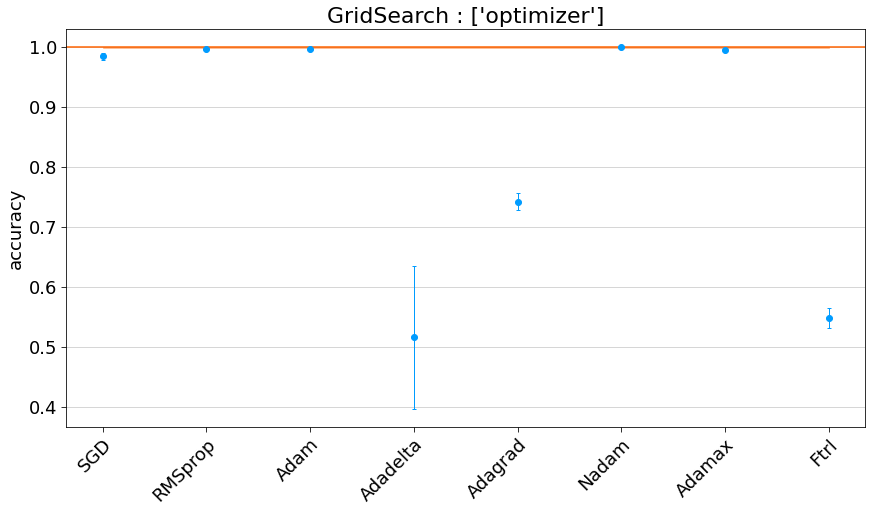

In [ ]:
# print grid search results
grid.print_result()

# plot grid search results
key = ["optimizer"]

fig = plt.figure(figsize=(12,7), constrained_layout=True)

ax = plot_utils.plot_gs_results(
    gs_results = [grid.grid_result],
    fig        = fig,
    fontsize   = 18,
    legend     = False,
    title      = f"GridSearch : {key}",
    key        = key,
    fill_box   = True,
    legend_title = None
)
ax.grid(axis="y", color="k", alpha=0.2)

plt.show()

In [ ]:
# update the model with best found value
model_gridsearch = model_gridsearch.set_params(optimizer='Nadam')

In [ ]:
## HIDDEN ACTIVATION
# define parameter list
hidden_activation = ['relu', 'elu', 'sigmoid', 'tanh', 'softmax', 'softsign', 'softplus', 'selu']
param_grid        = dict(hidden_activation         = hidden_activation)

# perform grid search
grid = gridsearch.GridSearch(x_train, y_train, model_gridsearch, param_grid)
grid.get_result()

GridSearchCV(cv=4,
             estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7f871a3adb50>,
             n_jobs=-1,
             param_grid={'hidden_activation': ['relu', 'elu', 'sigmoid', 'tanh',
                                               'softmax', 'softsign',
                                               'softplus', 'selu']})

Best: 0.997768 using {'hidden_activation': 'softsign'}
0.997768 (0.001481) with: {'hidden_activation': 'softsign'}
0.996875 (0.001946) with: {'hidden_activation': 'tanh'}
0.995536 (0.001996) with: {'hidden_activation': 'relu'}
0.993750 (0.001996) with: {'hidden_activation': 'elu'}
0.991964 (0.001546) with: {'hidden_activation': 'selu'}
0.978571 (0.007254) with: {'hidden_activation': 'softmax'}
0.935268 (0.016817) with: {'hidden_activation': 'softplus'}
0.919643 (0.019521) with: {'hidden_activation': 'sigmoid'}


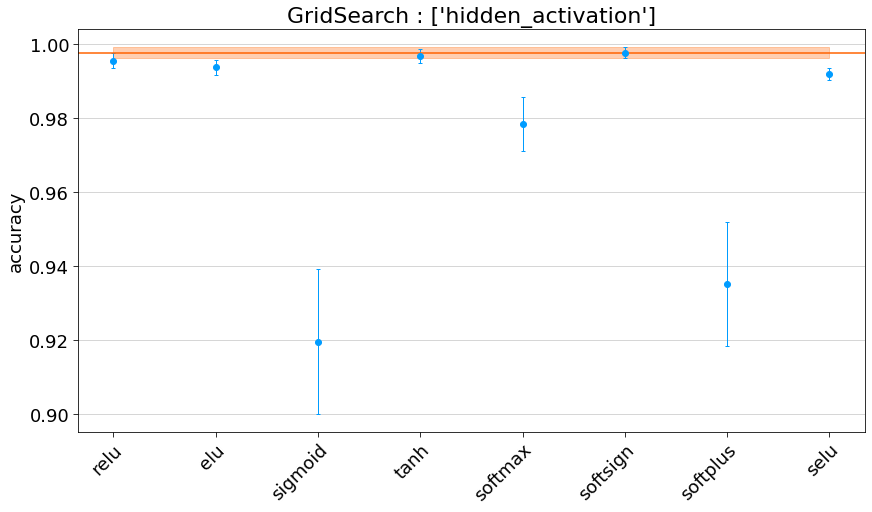

In [ ]:
# print grid search results
grid.print_result()

# plot grid search results
key = ["hidden_activation"]

fig = plt.figure(figsize=(12,7), constrained_layout=True)

ax = plot_utils.plot_gs_results(
    gs_results = [grid.grid_result],
    fig        = fig,
    fontsize   = 18,
    legend     = False,
    title      = f"GridSearch : {key}",
    key        = key,
    fill_box   = True,
    legend_title = None
)
ax.grid(axis="y", color="k", alpha=0.2)

plt.show()

In [ ]:
# update the model with best found value
model_gridsearch = model_gridsearch.set_params(hidden_activation='softsign')

In [ ]:
## LOSS
"""
binary_crossentropy and "hinge" losses are evaluated separately because we have to scale the labels for the
"hinge" losses, from {0,1} to {-1,1}
"""
# define parameter list
loss = ['binary_crossentropy']
param_grid = dict(loss = loss)

# perfrom grid search
grid = gridsearch.GridSearch(x_train, y_train, model_gridsearch, param_grid)
default_loss_grid = grid.get_result()

In [ ]:
# define parameter list
loss = ['hinge', 'squared_hinge']
param_grid = dict(loss = loss)

# rescale labels
y_train_hinge = y_train
y_train_hinge[y_train_hinge==0]=-1

# perfrom grid search
grid = gridsearch.GridSearch(x_train, y_train_hinge, model_gridsearch, param_grid)
hinge_losses_grid = grid.get_result()

In [ ]:
# concatenate grid search results
losses_grid = hinge_losses_grid.cv_results_
losses_grid["params"] = np.append(losses_grid["params"], default_loss_grid.cv_results_["params"][0])
losses_grid["mean_test_score"] = np.append(losses_grid["mean_test_score"], default_loss_grid.cv_results_["mean_test_score"][0])
losses_grid["std_test_score"] = np.append(losses_grid["std_test_score"], default_loss_grid.cv_results_["std_test_score"][0])

Best: 0.983482 using {'loss': 'squared_hinge'}
0.997768 (0.001946) with: {'loss': 'binary_crossentropy'}
0.983482 (0.006607) with: {'loss': 'squared_hinge'}
0.926786 (0.004374) with: {'loss': 'hinge'}


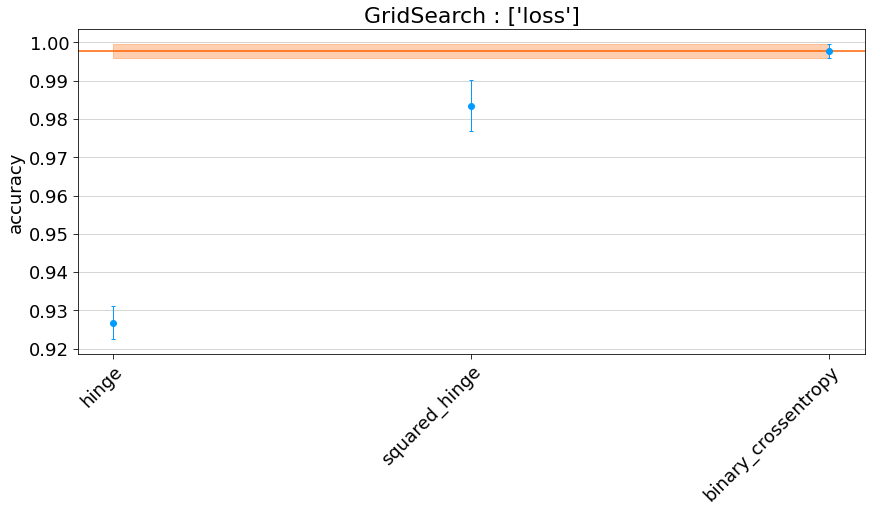

In [ ]:
# print overall grid search results
grid.print_result()

# plot overall grid search results
key = ["loss"]

fig = plt.figure(figsize=(12,7), constrained_layout=True)

ax = plot_utils.plot_gs_results(
    gs_results = [grid.grid_result],
    fig        = fig,
    fontsize   = 18,
    legend     = False,
    title      = f"GridSearch : {key}",
    key        = key,
    fill_box   = True,
    legend_title = None
)
ax.grid(axis="y", color="k", alpha=0.2)

plt.show()

As the default loss is the one with better performances we don't have to update the model.

In [ ]:
## EPOCHS
# define parameter list
N_epochs        = [10, 50, 100, 200, 300, 400]
param_grid = dict(epochs        = N_epochs)

# perfrom grid search
grid = gridsearch.GridSearch(x_train, y_train, model_gridsearch, param_grid)
grid.get_result()

GridSearchCV(cv=4,
             estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7f871a3adb50>,
             n_jobs=-1, param_grid={'epochs': [10, 50, 100, 200, 300, 400]})

Best: 0.997768 using {'epochs': 300}
0.997768 (0.000773) with: {'epochs': 300}
0.997321 (0.002679) with: {'epochs': 400}
0.996875 (0.001481) with: {'epochs': 200}
0.975446 (0.009138) with: {'epochs': 100}
0.925446 (0.015172) with: {'epochs': 50}
0.704018 (0.037188) with: {'epochs': 10}


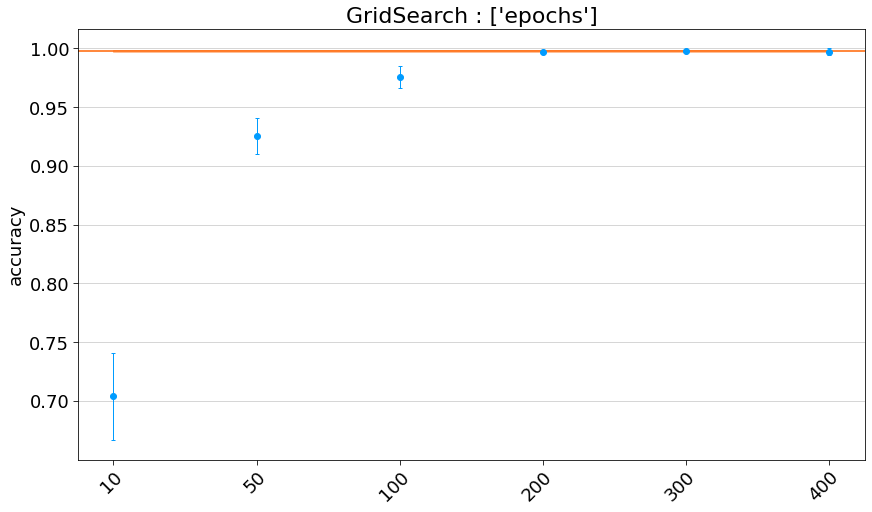

In [ ]:
# print grid search results
grid.print_result()

# plot grid search results
key = ["epochs"]

fig = plt.figure(figsize=(12,7), constrained_layout=True)

ax = plot_utils.plot_gs_results(
    gs_results = [grid.grid_result],
    fig        = fig,
    fontsize   = 18,
    legend     = False,
    title      = f"GridSearch : {key}",
    key        = key,
    fill_box   = True,
    legend_title = None
)
ax.grid(axis="y", color="k", alpha=0.2)

plt.show()

In [ ]:
# update the model
model_gridsearch = model_gridsearch.set_params(epochs=300)

In [ ]:
## BATCH_SIZE
# define parameter list
minibatch        = [N_train, 50, 100, 250, 500 , 1000]
param_grid = dict(batch_size        = minibatch)

# perfrom grid search
grid = gridsearch.GridSearch(x_train, y_train, model_gridsearch, param_grid)
grid.get_result()

GridSearchCV(cv=4,
             estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7f871a3adb50>,
             n_jobs=-1,
             param_grid={'batch_size': [2240, 50, 100, 250, 500, 1000]})

Best: 0.997321 using {'batch_size': 50}
0.997321 (0.001996) with: {'batch_size': 100}
0.997321 (0.001996) with: {'batch_size': 50}
0.986161 (0.006844) with: {'batch_size': 250}
0.966071 (0.013658) with: {'batch_size': 500}
0.897768 (0.026945) with: {'batch_size': 1000}
0.792857 (0.041515) with: {'batch_size': 2240}


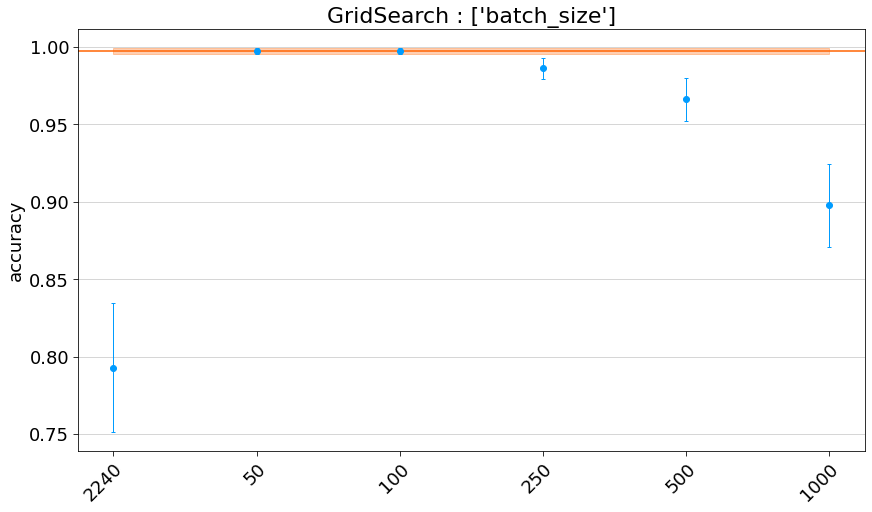

In [ ]:
# print grid search results
grid.print_result()

# plot grid search results
key = ["batch_size"]

fig = plt.figure(figsize=(12,7), constrained_layout=True)

ax = plot_utils.plot_gs_results(
    gs_results = [grid.grid_result],
    fig        = fig,
    fontsize   = 18,
    legend     = False,
    title      = f"GridSearch : {key}",
    key        = key,
    fill_box   = True,
    legend_title = None
)
ax.grid(axis="y", color="k", alpha=0.2)

plt.show()

In [ ]:
# update the model
model_gridsearch = model_gridsearch.set_params(batch_size=50)

Now we can take the best values for each parameter (i.e all the values within a $\sigma$ with respect to the best found value) and perform a total GridSearch over all the parameters of the cluster.

In [ ]:
## 1- TOTAL GRIDSEARCH
optimizer         = ['RMSprop', 'Adamax', 'Nadam', 'Adam']
hidden_activation = ['relu', 'tanh', 'softsign']
#N_epochs          = [400, 300, 200]
minibatch         = [50, 100]

param_grid = dict(optimizer         = optimizer,
                  hidden_activation = hidden_activation,
                  #epochs     = N_epochs,
                  batch_size = minibatch)

# perfrom grid search
grid = gridsearch.GridSearch(x_train, y_train, model_gridsearch, param_grid)
grid.get_result()

GridSearchCV(cv=4,
             estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7f871a3adb50>,
             n_jobs=-1,
             param_grid={'batch_size': [50, 100],
                         'hidden_activation': ['relu', 'tanh', 'softsign'],
                         'optimizer': ['RMSprop', 'Adamax', 'Nadam', 'Adam']})

Best: 0.998661 using {'batch_size': 50, 'hidden_activation': 'softsign', 'optimizer': 'Adam'}
0.998661 (0.000773) with: {'batch_size': 50, 'hidden_activation': 'softsign', 'optimizer': 'Adam'}
0.998214 (0.000000) with: {'batch_size': 50, 'hidden_activation': 'tanh', 'optimizer': 'RMSprop'}
0.997768 (0.001946) with: {'batch_size': 50, 'hidden_activation': 'tanh', 'optimizer': 'Adam'}
0.997768 (0.001946) with: {'batch_size': 50, 'hidden_activation': 'softsign', 'optimizer': 'RMSprop'}
0.997768 (0.000773) with: {'batch_size': 50, 'hidden_activation': 'softsign', 'optimizer': 'Nadam'}
0.997768 (0.001481) with: {'batch_size': 50, 'hidden_activation': 'relu', 'optimizer': 'Nadam'}
0.997321 (0.001546) with: {'batch_size': 50, 'hidden_activation': 'tanh', 'optimizer': 'Nadam'}
0.996875 (0.000773) with: {'batch_size': 100, 'hidden_activation': 'tanh', 'optimizer': 'RMSprop'}
0.996429 (0.002525) with: {'batch_size': 100, 'hidden_activation': 'tanh', 'optimizer': 'Adam'}
0.995982 (0.001481) with:

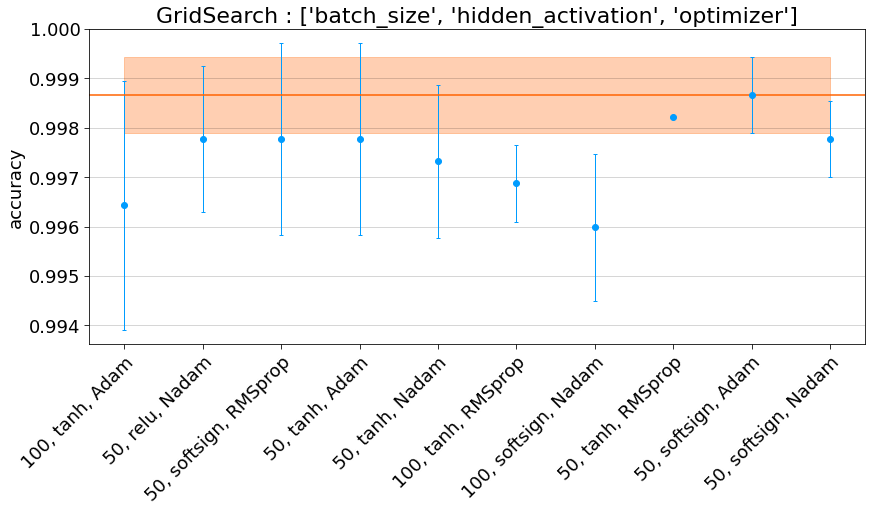

In [ ]:
# print grid search results
grid.print_result()

# plot grid search results
key = ["batch_size", "hidden_activation", "optimizer"]

fig = plt.figure(figsize=(12,7), constrained_layout=True)

ax = plot_utils.plot_gs_results(
    gs_results = [grid.grid_result],
    fig        = fig,
    fontsize   = 18,
    legend     = False,
    title      = f"GridSearch : {key}",
    key        = key,
    fill_box   = True,
    legend_title = None,
    max_comb   = 10
)
ax.grid(axis="y", color="k", alpha=0.2)

plt.show()

Here we plotted only the best 10 combinations of parameters. As three options are totally equivalent we can choose the one that we think will perfrom better on the whole dataset.

In [ ]:
# update the model
model_gridsearch = model_gridsearch.set_params(batch_size=50, hidden_activation='softsign', optimizer='Adam')

#### 2 - Architecture & Dropout parameters 

Firstly, we consider different shapes for out architecture keeping a smiliar number of total neurons. Given *h* and *w* respectively the height and width of the architecture, we consider the following scenarios:

- *h*>>*w*
- *h*<<*w*
- *h*=*w*


In [ ]:
## DIFFERENT NN SHAPES
# list of different shapes: h>>w, h<<w, h=w
neurons        = [ [20,20,1], [4 for i in range(10)]+[1], [6 for i in range(6)]+[1]]
param_grid = dict(neurons = neurons)

# perfrom grid search
grid = gridsearch.GridSearch(x_train, y_train, model_gridsearch, param_grid)
grid.get_result()

GridSearchCV(cv=4,
             estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7f871a3adb50>,
             n_jobs=-1,
             param_grid={'neurons': [[20, 20, 1],
                                     [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1],
                                     [6, 6, 6, 6, 6, 6, 1]]})

Best: 0.999107 using {'neurons': [20, 20, 1]}
0.999107 (0.000893) with: {'neurons': [20, 20, 1]}
0.987500 (0.003341) with: {'neurons': [6, 6, 6, 6, 6, 6, 1]}
0.914286 (0.022482) with: {'neurons': [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1]}
[2 1 0]


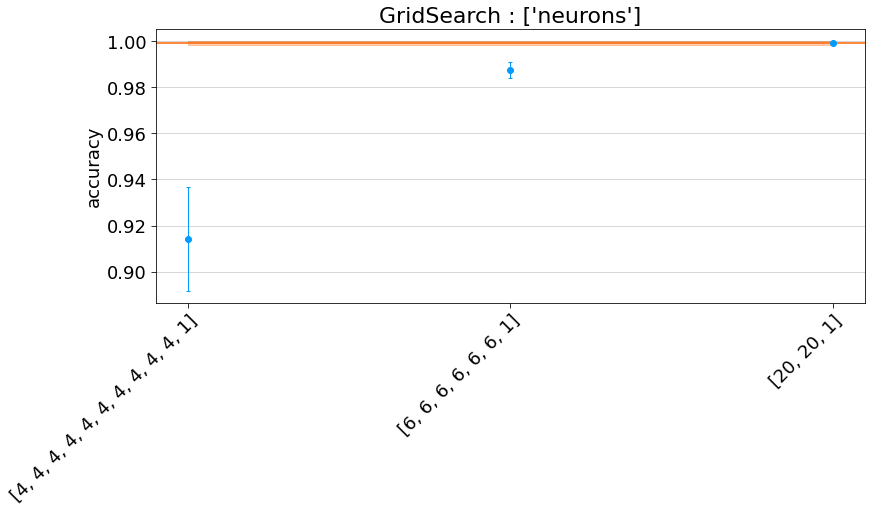

In [ ]:
# print grid search results
grid.print_result()

# plot grid search results
key = ["neurons"]

fig = plt.figure(figsize=(12,7), constrained_layout=True)

ax = plot_utils.plot_gs_results(
    gs_results = [grid.grid_result],
    fig        = fig,
    fontsize   = 18,
    legend     = False,
    title      = f"GridSearch : {key}",
    key        = key,
    fill_box   = True,
    legend_title = None
)
ax.grid(axis="y", color="k", alpha=0.2)

plt.show()

It's clear how the *h*>>*w* shape is preferred over the other possibilities. Now we can consider different number of neurons keeping the shape fixed.

In [ ]:
## DIFFERENT number of NEURONS
# parameter list
neurons        = [[5,5,1], [20,20,1], [100,100,1], [500,500,1]]
param_grid = dict(neurons = neurons)

# perform grid search
grid = gridsearch.GridSearch(x_train, y_train, model_gridsearch, param_grid)
grid.get_result()

GridSearchCV(cv=4,
             estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7f871a3adb50>,
             n_jobs=-1,
             param_grid={'neurons': [[5, 5, 1], [20, 20, 1], [100, 100, 1],
                                     [500, 500, 1]]})

Best: 0.998661 using {'neurons': [100, 100, 1]}
0.998661 (0.000773) with: {'neurons': [100, 100, 1]}
0.997321 (0.001996) with: {'neurons': [20, 20, 1]}
0.990625 (0.005413) with: {'neurons': [500, 500, 1]}
0.924554 (0.003866) with: {'neurons': [5, 5, 1]}


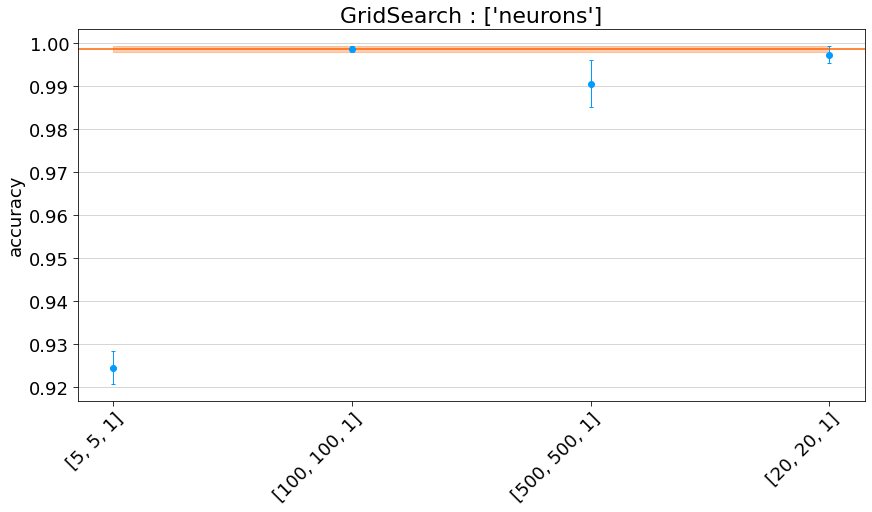

In [ ]:
# print grid search results
grid.print_result()

# plot grid search results
key = ["neurons"]

fig = plt.figure(figsize=(12,7), constrained_layout=True)

ax = plot_utils.plot_gs_results(
    gs_results = [grid.grid_result],
    fig        = fig,
    fontsize   = 18,
    legend     = False,
    title      = f"GridSearch : {key}",
    key        = key,
    fill_box   = True,
    legend_title = None
)
ax.grid(axis="y", color="k", alpha=0.2)

plt.show()

In [ ]:
# update the model
model_gridsearch = model_gridsearch.set_params(neurons=[100, 100, 1])

Once the architecture shape is optimized we can try different values for the dropout parameters, we can apply the dropout with a rate from $0.1$ to $0.5$ after the first layer (input layer is layer 0) or after the second one.

In [ ]:
## DROPOUT PARAMS
# parameters list
dropout_rates        = [[i/10] for i in range(6)]
dropout_layers       = [[1], [2]]
param_grid = dict(dropout_rates        = dropout_rates,
                  dropout_arc          = dropout_layers)

# perfrom grid search
grid = gridsearch.GridSearch(x_train, y_train, model_gridsearch, param_grid)
grid.get_result()

GridSearchCV(cv=4,
             estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7f23280d4b50>,
             n_jobs=-1,
             param_grid={'dropout_arc': [[1], [2]],
                         'dropout_rates': [[0.0], [0.1], [0.2], [0.3], [0.4],
                                           [0.5]]})

Best: 0.998661 using {'dropout_arc': [1], 'dropout_rates': [0.2]}
0.998661 (0.000773) with: {'dropout_arc': [1], 'dropout_rates': [0.2]}
0.998661 (0.001481) with: {'dropout_arc': [1], 'dropout_rates': [0.3]}
0.997768 (0.000773) with: {'dropout_arc': [1], 'dropout_rates': [0.1]}
0.996875 (0.001946) with: {'dropout_arc': [1], 'dropout_rates': [0.4]}
0.996429 (0.001786) with: {'dropout_arc': [1], 'dropout_rates': [0.5]}
0.991071 (0.002823) with: {'dropout_arc': [2], 'dropout_rates': [0.3]}
0.990625 (0.001481) with: {'dropout_arc': [2], 'dropout_rates': [0.2]}
0.989286 (0.005504) with: {'dropout_arc': [2], 'dropout_rates': [0.5]}
0.989286 (0.002823) with: {'dropout_arc': [2], 'dropout_rates': [0.4]}
0.987946 (0.006726) with: {'dropout_arc': [1], 'dropout_rates': [0.0]}
0.987054 (0.006105) with: {'dropout_arc': [2], 'dropout_rates': [0.0]}
0.985714 (0.003993) with: {'dropout_arc': [2], 'dropout_rates': [0.1]}


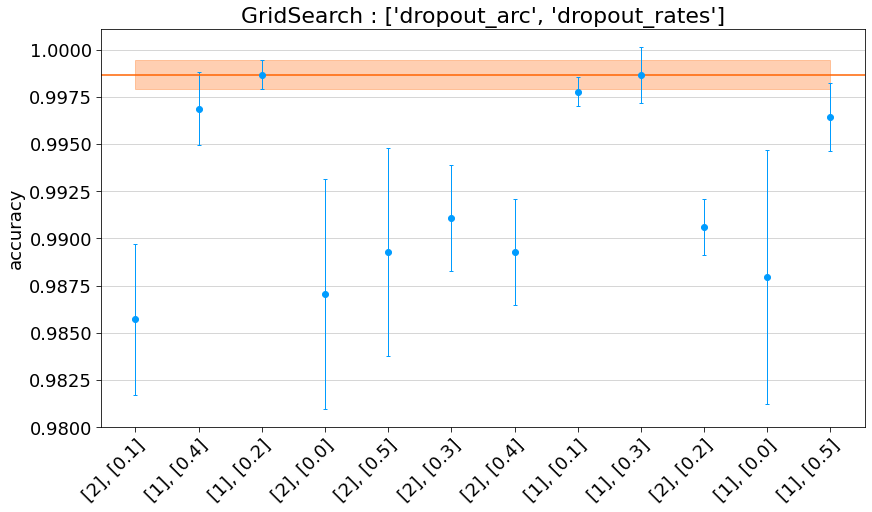

In [ ]:
# print grid search results
grid.print_result()

# plot grid search results
key = ["dropout_arc", "dropout_rates"]

fig = plt.figure(figsize=(12,7), constrained_layout=True)

ax = plot_utils.plot_gs_results(
    gs_results = [grid.grid_result],
    fig        = fig,
    fontsize   = 18,
    legend     = False,
    title      = f"GridSearch : {key}",
    key        = key,
    fill_box   = True,
    legend_title = None
)
ax.grid(axis="y", color="k", alpha=0.2)

plt.show()

The preferred layer after which apply dropout is clearly the first, the lower rates have similar performances.

In [ ]:
# update the model
model_gridsearch = model_gridsearch.set_params(dropout_arc=[1])

In [ ]:
## 2- TOTAL GRID
neurons              = [[100, 100,1], [20,20,1], [500,500,1]]
dropout_rates        = [[i/10] for i in range(1,4)]

param_grid = dict(neurons        = neurons,
                  dropout_rates  = dropout_rates)

# perform grid search
grid = gridsearch.GridSearch(x_train, y_train, model_gridsearch, param_grid)
grid.get_result()

GridSearchCV(cv=4,
             estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7f23280d4b50>,
             n_jobs=-1,
             param_grid={'dropout_rates': [[0.1], [0.2], [0.3]],
                         'neurons': [[100, 100, 1], [20, 20, 1],
                                     [500, 500, 1]]})

Best: 0.998214 using {'dropout_rates': [0.3], 'neurons': [20, 20, 1]}
0.998214 (0.000000) with: {'dropout_rates': [0.3], 'neurons': [20, 20, 1]}
0.997768 (0.002320) with: {'dropout_rates': [0.2], 'neurons': [100, 100, 1]}
0.996875 (0.001481) with: {'dropout_rates': [0.3], 'neurons': [100, 100, 1]}
0.996875 (0.001481) with: {'dropout_rates': [0.2], 'neurons': [20, 20, 1]}
0.996875 (0.001481) with: {'dropout_rates': [0.1], 'neurons': [100, 100, 1]}
0.996875 (0.001946) with: {'dropout_rates': [0.1], 'neurons': [20, 20, 1]}
0.991964 (0.003892) with: {'dropout_rates': [0.3], 'neurons': [500, 500, 1]}
0.991071 (0.004374) with: {'dropout_rates': [0.2], 'neurons': [500, 500, 1]}
0.988393 (0.001996) with: {'dropout_rates': [0.1], 'neurons': [500, 500, 1]}


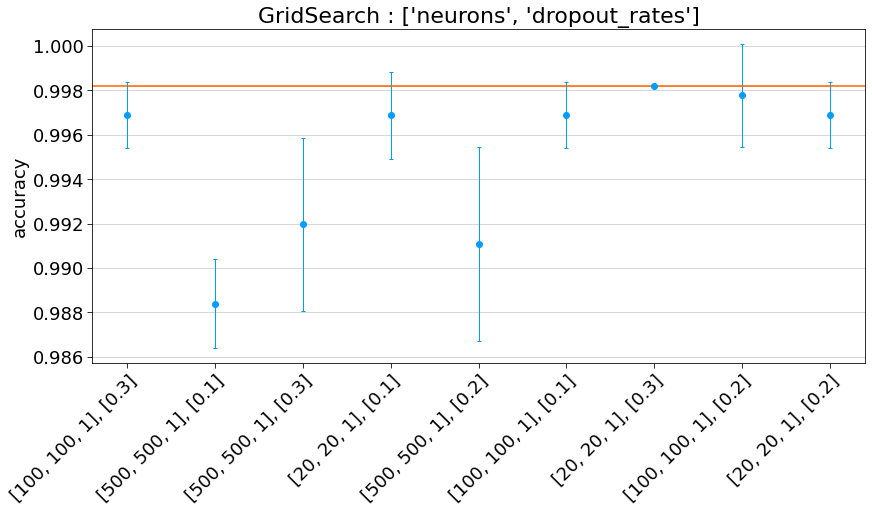

In [ ]:
# print grid search results
grid.print_result()

# plot grid search results
key = ["neurons", "dropout_rates"]

fig = plt.figure(figsize=(12,7), constrained_layout=True)

ax = plot_utils.plot_gs_results(
    gs_results = [grid.grid_result],
    fig        = fig,
    fontsize   = 18,
    legend     = False,
    title      = f"GridSearch : {key}",
    key        = key,
    fill_box   = True,
    legend_title = None
)
ax.grid(axis="y", color="k", alpha=0.2)

plt.show()

In [ ]:
# update the model
model_gridsearch = model_gridsearch.set_params(dropout_rates=[0.3], neurons=[20, 20, 1])

### Fit and evaluate the test set with the best model

Let's have a look at out model after the tuning of its hyperparameters

In [ ]:
# check current model
model_gridsearch.get_params()

{'n_features': 2,
 'epochs': 300,
 'batch_size': 50,
 'hidden_activation': 'softsign',
 'optimizer': 'Adam',
 'dropout_rates': [0.3],
 'neurons': [20, 20, 1],
 'build_fn': <function __main__.create_model(n_features, neurons=[20, 20, 1], dropout_arc=[1], dropout_rates=[0.2], hidden_activation='relu', batch_norm_arc=None, output_activation='sigmoid', name='my lovely neural network', loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])>}

Next we must fit the model over the whole training set

In [ ]:
fit = model_gridsearch.fit(x_train, y_train, validation_data=(x_valid, y_valid), verbose=0)

Here we plot the loss and accuracy computed on the train and test set along the training process.

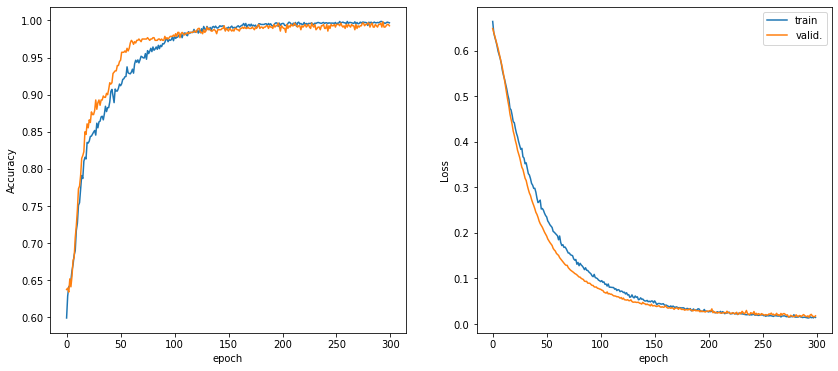

In [ ]:
fig,AX=plt.subplots(1,2,figsize=(14,6.))
ax=AX[0]
ax.plot(fit.history['accuracy'],label="train")
ax.plot(fit.history['val_accuracy'],label="valid.")
ax.set_xlabel('epoch')
ax.set_ylabel("Accuracy")
ax=AX[1]
ax.plot(fit.history['loss'],label="train")
ax.plot(fit.history['val_loss'],label="valid.")
ax.set_xlabel('epoch')
ax.set_ylabel("Loss")
ax.legend()

Then, we can evaluate the effectivness of out optimization procedure predicting the labels of our test set. An immediate outlook of the model performances is provided thanks to the confusion matrix plot.

In [ ]:
y_pred =model_gridsearch.predict(x_test)

pred_binary = y_pred.copy()
pred_binary[y_pred <= 0.5] = 0
pred_binary[y_pred >  0.5] = 1

cm = confusion_matrix(y_test, plot_utils.flatten(pred_binary))

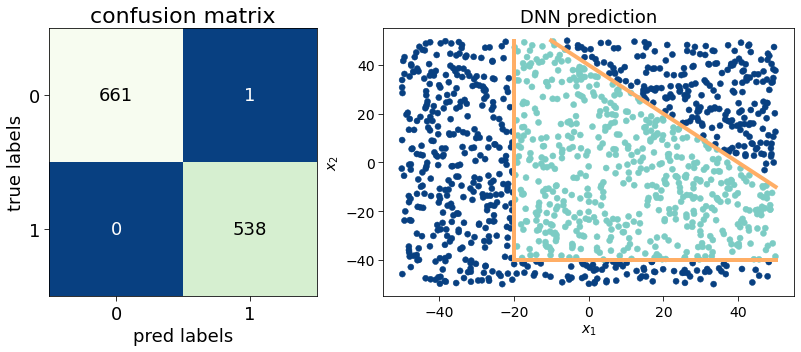

In [ ]:
fig = plt.figure(figsize=(12,5), constrained_layout=True)

# plot confusion matrix
ax = fig.add_subplot(121)

plot_utils.plot_confusion_matrix(
    cm = cm,
    ax = ax,
    title = "confusion matrix"
)
# plot predictions

# scale back x data
mean = np.mean(x, axis=0)
std = np.std(x, axis=0)

ax  = plot_utils.plot_labeled_data(
        x               = x_test*std+mean, 
        labels          = plot_utils.flatten(y_pred), 
        fig             = fig, 
        subplot_id      = 122,
        title           = "DNN prediction", 
        palette         = "GnBu_r",
        hue_norm        = (0, 2),
        fontsize        = 14, 
        legend          = False 
    )
plot_utils.boundaries(ax)
    
plt.show()

## 3 - Check whether any other rescaling of data or initialization of weights may improve the accuracy of the DNN

### Data rescalings

Next, we create identical copies of our dataset and apply a different data rescaling to each one of them. This way, we can test our model behaviour under a change in mean and variance of the same data. 

We thus define three data rescalings, with their implementation located in ```preprocess.py```:

1) No rescaling
2) Standardization
3) Normalization

The first one is as straightforward as it seems: we simply do not apply any rescaling to our data to see whether rescaling input data is relevant to achieve a satisfactory result. The second one, standardization, is probably the most common rescaling scenarios on this kind. It can be translated into a function $std(x)$ as follows:

$$
    x' = std(x) = \frac{x-\bar{x}}{\sigma(x)}
$$

where $\sigma(x)$ is a vector whose components are the standard deviations of $x$ along each of its dimensions. 

The last one instead, normalization, is a simple shift and shrink to fit data into a $\mathcal{D}'\equiv [0,\,1]\times[0,\,1]$ box, namely:

$$
    x' = norm(x) = \frac{x-x_{\text{min}}}{x_{\text{max}}-x_{\text{min}}}
$$

where $x_{\text{min}}$ and $x_{\text{max}}$ are vectors of the minimum and maximum values of the input dataset, along each of its dimension, respectively.

A visual representation of the three different input datasets is shown below. 

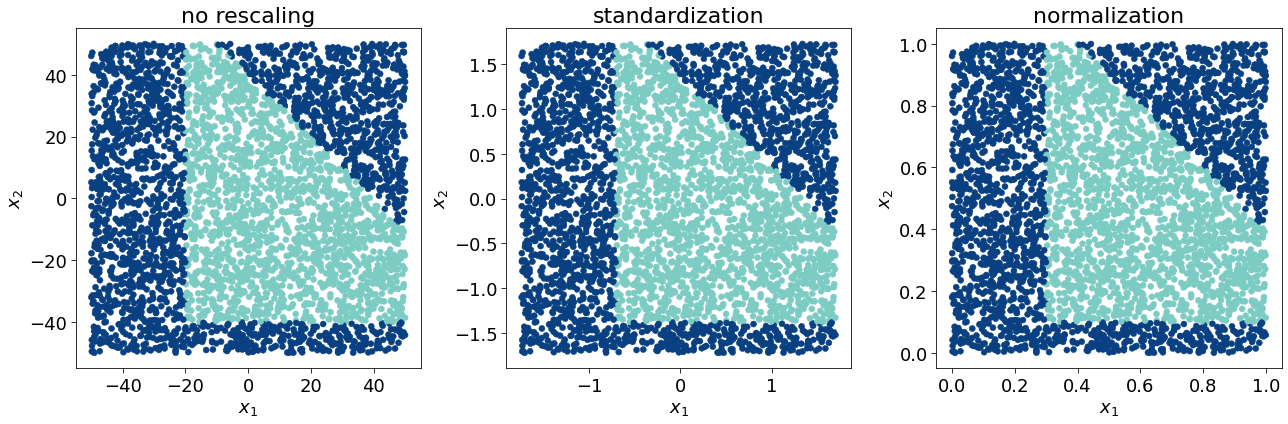

In [ ]:
mean = np.mean(x, axis=0) 
std  = np.std(x, axis=0)

# no rescaling
x_nr   = np.copy(x)
# standardization
x_std  = preprocess.standardize(x, mean, std)
# normalization
x_norm = preprocess.normalize(x)

dataset = np.array([x_nr, x_std, x_norm])
titles  = ["no rescaling", "standardization", "normalization"]

fig = plt.figure(figsize=(18,6), constrained_layout=True)

for i, data in enumerate(dataset):
    ax  = plot_utils.plot_labeled_data(
        x               = data, 
        labels          = y_true, 
        fig             = fig, 
        subplot_id      = 131+i,
        title           = titles[i], 
        palette         = "GnBu_r",
        hue_norm        = (0, 2),
        fontsize        = 18, 
        legend          = False 
    )
plt.show()

#### Training, test, validation

Now that we have the three differently rescaled datasets we split each of them into three subsets: *training set*, *validation set* and *test set*. These three subsets of the input data are used in different steps of the neural network implementation, namely training, validating and testing the model. 

The key feature of these three subsets is that they are disjoint sets, i.e. they do not share *any* example $x\in\mathcal{D}$ and thus $\mathcal{D}_{\text{train}} \cap \mathcal{D}_{\text{valid}} \cap \mathcal{D}_{\text{test}} = \emptyset$.

In [ ]:
train_test_frac  = 0.7
valid_train_frac = 0.2 

N_train = int(N*train_test_frac*(1-valid_train_frac))
N_valid = int(N*train_test_frac*valid_train_frac)
N_test  = int(N*(1-train_test_frac))

train_idx = N_train
valid_idx = N_train + N_valid
test_idx  = N_train + N_valid + N_test

data_split = {
    "training_set"   : N_train,
    "test_set"       : N_test,
    "validation_set" : N_valid
}

for key, val in data_split.items():
    print(f"{key} \t N = {val}")

training_set      = []
training_labels   = []
test_set          = []
test_labels       = []
validation_set    = []
validation_labels = []

for data in dataset:

    training_set.append(data[0:train_idx])
    training_labels.append(y_true[0:train_idx])

    validation_set.append(data[train_idx:valid_idx])
    validation_labels.append(y_true[train_idx:valid_idx])

    test_set.append(data[valid_idx:test_idx])
    test_labels.append(y_true[valid_idx:test_idx])

#### Neural network hyper-parameters

Now we start implementing the neural network model. First, we define its hyperparameters as the best values we have found using GridSearchCV beforehand.

In [ ]:
N_features = x.shape[1]

## NN hyperparameter

architecture      = [N_features, 20, 20, 1]
dropout_arc       = [1] 
dropout_rates     = [0.2] 
batch_norm_arc    = None   
input_dim         = architecture[0]
hidden_activation = "relu"
output_activation = "sigmoid"
name              = "my lovely neural network"

loss      = "binary_crossentropy"
optimizer = "RMSprop"
metrics   = ["accuracy"]

minibatch = 100
N_epochs  = 400

#### Training

Then we create one model for each of the three rescalings. We train these models using the validation set for an in-training accuracy evaluation on an "unseen" data sample. 

We finally print out the end-of-training loss and accuracy on both the training set and the validation set. On top of that, at the very end of the training procedure, we evaluate the three models on the test set to get a final evaluation of performance. 

In [ ]:
networks    = []
fit_results = []

for i in range(len(dataset)):

    name = f"{titles[i]} network"

    network = nn_model.create_model(
        input_dim         = input_dim,
        architecture      = architecture,
        dropout_layers    = dropout_arc,
        dropout_rates     = dropout_rates,
        batch_norm_layers = batch_norm_arc,
        hidden_activation = hidden_activation,
        output_activation = output_activation,
        loss              = loss,
        optimizer         = optimizer,
        metrics           = metrics,
        nn_name           = name,
    )

    # network.summary()

    t0 = time.time()
    fit = network.fit(
        training_set[i], training_labels[i],
        epochs          = N_epochs,
        batch_size      = minibatch,
        validation_data = (validation_set[i], validation_labels[i]),
        verbose         = 0,
    )
    t1 = time.time()

    test = network.evaluate(
        test_set[i], test_labels[i],
        batch_size      = minibatch,
        verbose         = 0,
    )


    print("="*30)
    print(f"\n{titles[i]} training : {t1-t0:.2f} seconds")

    print(f"\ntraining loss     : {fit.history['loss'][-1]:.5f}")
    print(f"training accuracy : {fit.history['accuracy'][-1]:.5f}")

    print(f"\nvalid loss        : {fit.history['val_loss'][-1]:.5f}")
    print(f"valid accuracy    : {fit.history['val_accuracy'][-1]:.5f}\n")

    print(f"\n{titles[i]} testing")

    print(f"\ntest loss         : {test[0]:.5f}")
    print(f"test accuracy     : {test[1]:.5f}\n")

    print("="*30)

    networks.append(network)
    fit_results.append(fit)

After that, we plot the accuracy and the loss over the training epochs for both the training and the validation set, color-coded by data rescalings. 

In [ ]:
palette = {
    "no rescaling"   : ["#009cff", "#ff6300"],
    "standardization": ["#44db34", "#cb34db"],
    "normalization"  : ["#db3444", "#7834db"]
}

fig, (ax1, ax2) = plt.subplots(
    nrows              = 1, 
    ncols              = 2, 
    sharex             = "all", 
    sharey             = "all",
    figsize            = (14,6), 
    constrained_layout = True
)
fig.suptitle("Loss function", fontsize=24)

ax1.grid(axis="y", color="k", alpha=0.2, which="both")
ax2.grid(axis="y", color="k", alpha=0.2, which="both")

for i, fit in enumerate(fit_results):

    ax1 = plot_utils.plot_loss(
        epochs     = N_epochs,
        loss       = fit.history["loss"],
        fig        = fig,
        ax         = ax1,
        color      = palette[titles[i]][0],
        loss_label = "loss",
        title      = "training",
        label      = f"{titles[i]}",
    )
    ax2 = plot_utils.plot_loss(
        epochs = N_epochs,
        loss   = fit.history["val_loss"],
        fig    = fig,
        ax     = ax2,
        color  = palette[titles[i]][0],
        title  = "validation",
        label  = f"{titles[i]}",
    )

ax1.set_yscale("log")

plt.show()


## ====================================================##


fig, (ax1, ax2) = plt.subplots(
    nrows              = 1, 
    ncols              = 2, 
    sharex             = "all", 
    sharey             = "all",
    figsize            = (14,6), 
    constrained_layout = True
)
fig.suptitle("Accuracy", fontsize=24)

ax1.grid(axis="y", color="k", alpha=0.2)
ax2.grid(axis="y", color="k", alpha=0.2)

for i, fit in enumerate(fit_results):

    ax1 = plot_utils.plot_metric(
        epochs       = N_epochs,
        metric       = fit.history["accuracy"],
        fig          = fig,
        ax           = ax1,
        color        = palette[titles[i]][0],
        metric_label = "accuracy",
        title        = "training",
        label        = f"{titles[i]}",
    )
    ax2 = plot_utils.plot_metric(
        epochs       = N_epochs,
        metric       = fit.history["val_accuracy"],
        fig          = fig,
        ax           = ax2,
        color        = palette[titles[i]][0],
        title        = "validation",
        label        = f"{titles[i]}",
    )

ax1.set_yscale("linear")

plt.show()

We see that the standardization rescaling leads to an overall faster and more accurate model. 

### Weights and biases

Now we also plot a layer-by-layer histogram of weights and biases to check whether there are significant differences between different data rescalings.

In [ ]:
for i, network in enumerate(networks):

    weights = network.get_weights()

    axes = plot_utils.plot_weights(
        weights  = weights,
        figsize  = (14, 18),
        suptitle = titles[i],
    )

    plt.show()

We cannot detect any significant differences in the weights distributions, as they all share approximately the same range of variability. Notice that this range becomes bigger as we advance into the following layers due to the ReLU activation function. 

### Neural network predictions on *test set*

Finally, we can use our trained models to predict the labels of the test sets. This allows us to build confusion matrices and compute the *sensitivity* and *specificity* of our models. In other words, we want to quantitatively assess how well our models perform on unseen data, and we aim to do so by checking true positives, true negatives, false positives and false negatives rates. 

In [ ]:
predictions        = []
binary_predictions = []
confusion_matrices = []

for i in range(len(dataset)):

    y_pred = networks[i].predict(test_set[i])
    predictions.append(plot_utils.flatten(y_pred))

    pred_binary = y_pred.copy()
    pred_binary[y_pred <= 0.5] = 0
    pred_binary[y_pred >  0.5] = 1
    binary_predictions.append(plot_utils.flatten(pred_binary))

    cm = confusion_matrix(test_labels[i], plot_utils.flatten(pred_binary))
    confusion_matrices.append(cm)

In [ ]:
labels = [0, 1]
fontsize=18

fig = plt.figure(figsize=(15,5), constrained_layout=True)

for i, cm in enumerate(confusion_matrices):

    ax = fig.add_subplot(131+i)

    total_0, total_1 =  np.sum(cm, axis=1)
 
    cm_norm_0 = cm[0]/total_0
    cm_norm_1 = cm[1]/total_1

    cm_norm = np.vstack((cm_norm_0, cm_norm_1))

    plot_utils.plot_confusion_matrix(
        cm = cm_norm,
        ax = ax,
        title = titles[i]
    )
    

plt.show()

From the three confusion matrices above, we can clearly see that the "no rescaling" option leads to a high false negatives rate if compared to the other two rescalings. However, "standardization" and "normalization" lead to similar results, both sharing a low rate of false positives and false negatives. Note that "standardization" lead to no false positives (i.e. perfect detection of label 0) but a slightly higher rate of false negatives if compared to the "normalization" option. 

In [ ]:
fig1 = plt.figure(figsize=(15,5))
fig1.suptitle("Real data", fontsize=24)
fig2 = plt.figure(figsize=(15,5))
fig2.suptitle("Neural network predictions", fontsize=24)
for i in range(len(dataset)):

    ax = plot_utils.plot_labeled_data(
        x               = test_set[0], 
        labels          = test_labels[i],
        fig             = fig1, 
        subplot_id      = 131+i,
        title           = titles[i], 
        palette         = "GnBu_r",
        hue_norm        = (0, 2),
        fontsize        = 14, 
        legend          = False 
    )
    plot_utils.boundaries(ax, lw=1, color="w")

    ax = plot_utils.plot_labeled_data(
        x               = test_set[0], 
        labels          = binary_predictions[i], 
        fig             = fig2, 
        subplot_id      = 131+i,
        title           = titles[i], 
        palette         = "GnBu_r",
        hue_norm        = (0, 2),
        fontsize        = 14, 
        legend          = False 
    )
    plot_utils.boundaries(ax, lw=1, color="w")


plt.show()

### Weights initializers

In this section we check whether different weights initializations lead to sensibily different results. 

The initializers we test are:

1) RandomNormal
2) RandomUniform
3) TruncatedNormal
4) GlorotNormal
5) GlorotUniform
6) HeNormal
7) HeUniform

A detailed description of these kernel initializers can be found [here](https://keras.io/api/layers/initializers/). 


#### Neural network hyper-parameters

Here we set the neural network hyperparameters and create a list with aliases for the weights initializers reported above.

In [ ]:
N_features = x.shape[1]

## NN hyperparameter

architecture      = [N_features, 20, 20, 1]
dropout_arc       = [2] # [2]
dropout_rates     = [0.2] # [0.2]
batch_norm_arc    = None # [2]   
input_dim         = architecture[0]
hidden_activation = "relu"
output_activation = "sigmoid"
name              = "my lovely neural network"

loss      = "binary_crossentropy"
optimizer = "RMSprop"
metrics   = [
    tf.keras.metrics.Accuracy(name="accuracy"),
]

# list of initializers 
initializer_list = [
    "random_normal",
    "random_uniform",
    "truncated_normal",
    "glorot_normal",
    "glorot_uniform",
    "he_normal",
    "he_uniform",
    # "zeros",
    # "ones",
]

### GridSearch cross validation

Now, for each data rescaling (no rescaling, standardiation and normalization), we exploit

1) ```sklearn.model_selection.GridSearchCV```
2) ```keras.wrappers.scikit_learn.KerasClassifier```

to implement a grid search over the weights initializers list. 

The output of the following cell will contain the score for each kernel initializer.

In [ ]:
N_epochs  = 200
minibatch = 64

grid_search_results = []

gs_means, gs_stds, gs_params = [], [], []

predictions        = []
binary_predictions = []

confusion_matrices = []

for i in range(len(dataset)):

    model_gridsearch = KerasClassifier(
        build_fn          = nn_model.create_model, 
        input_dim         = input_dim,
        architecture      = architecture,
        epochs            = N_epochs, 
        batch_size        = minibatch
    )

    param_grid = dict(initializer = initializer_list)

    grid_search = GridSearchCV(estimator=model_gridsearch, param_grid=param_grid, n_jobs=-1, cv=4)

    grid_result = grid_search.fit(
        training_set[i], training_labels[i],
        # batch_size = minibatch,
        verbose    = 0,
    )

    grid_search_results.append(grid_result)


    # summarize results
    print("="*30)
    print()
    print(titles[i])
    print()
    print("Best model    : %.4f using %s" % (grid_result.best_score_, grid_result.best_params_))
    print()

    means  = grid_result.cv_results_['mean_test_score']
    stds   = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']

    gs_means.append(means)
    gs_stds.append(stds)
    gs_params.append(params)

    for mean, stdev, param in zip(means, stds, params):
        print("%.4f (%.4f) with: %r" % (mean, stdev, param))
    print()
    print("="*30)

    

    # y_pred = grid_search.predict(test_set[i])
    # predictions.append(plot_utils.flatten(y_pred))

    # pred_binary = y_pred.copy()
    # pred_binary[y_pred <= 0.5] = 0
    # pred_binary[y_pred >  0.5] = 1
    # binary_predictions.append(plot_utils.flatten(pred_binary))

    # cm = confusion_matrix(test_labels[i], plot_utils.flatten(pred_binary))
    # confusion_matrices.append(cm)

### GridSearch results

To gain a better understanding of the grid search results, it is better to visualize the returned scores.

In [ ]:
fig = plt.figure(figsize=(12,7), constrained_layout=True)

ax = plot_utils.plot_gs_results(
    gs_results = grid_search_results,
    fig        = fig,
    fontsize   = 18,
    colors     = palette,
    labels     = titles,
    legend     = True,
    title      = "GridSearch : weights initializers"
)
ax.grid(axis="y", color="k", alpha=0.2)

plt.show()

From the figure above we can clearly see that the "standardization" rescaling always outouts better accuracies and we deduce that it is the most robust data rescaling we can apply. Instead, network performance under "no rescaling" and "normalization" rescaling is more influenced by the weights initializer. Nevertheless, as we have seen in the previous section, the "normalization" rescaling gives, on average, a better result than  the "no rescaling" option. 

We can also see that if we do not apply any rescaling to our data we get more variance in network performance under different weights initializers. We thus deduce that rescaling data is necessary to get a more robust model that has a lower 

### Training the best model

Next we take the best model, i.e. we set the weights initializer to the one that had the highest accuracy in the previous grid search, and train the model again. This because when running ```sklearn.model_selection.GridSearchCV.fit()``` models created do not see the whole training set. 

In [ ]:
N_features = x.shape[1]

## NN hyperparameter

architecture      = [N_features, 20, 20, 1]
dropout_arc       = [2] # [1]
dropout_rates     = [0.2] # [0.2]
batch_norm_arc    = None # [2]   
input_dim         = architecture[0]
hidden_activation = "relu"
output_activation = "sigmoid"
name              = "my lovely neural network"

loss      = "binary_crossentropy"
optimizer = "RMSprop"
metrics   = ["accuracy"]
initializer_list = [
    "random_uniform",
    "random_normal",
    "random_normal",
]

minibatch = 64
N_epochs  = 200

In [ ]:
networks    = []
fit_results = []

for i in range(len(dataset)):

    name = f"{titles[i]} network"

    network = nn_model.create_model(
        input_dim         = input_dim,
        architecture      = architecture,
        dropout_layers    = dropout_arc,
        dropout_rates     = dropout_rates,
        batch_norm_layers = batch_norm_arc,
        hidden_activation = hidden_activation,
        output_activation = output_activation,
        loss              = loss,
        optimizer         = optimizer,
        initializer       = initializer_list[i],
        metrics           = metrics,
        nn_name           = name,
    )

    # network.summary()

    t0 = time.time()
    fit = network.fit(
        training_set[i], training_labels[i],
        epochs          = N_epochs,
        batch_size      = minibatch,
        validation_data = (validation_set[i], validation_labels[i]),
        verbose         = 0,
    )
    t1 = time.time()

    test = network.evaluate(
        test_set[i], test_labels[i],
        batch_size      = minibatch,
        verbose         = 0,
    )


    print("="*30)
    print(f"\n{titles[i]} training : {t1-t0:.2f} seconds")

    print(f"\ntraining loss     : {fit.history['loss'][-1]:.5f}")
    print(f"training accuracy : {fit.history['accuracy'][-1]:.5f}")

    print(f"\nvalid loss        : {fit.history['val_loss'][-1]:.5f}")
    print(f"valid accuracy    : {fit.history['val_accuracy'][-1]:.5f}\n")

    print(f"\n{titles[i]} testing")

    print(f"\ntest loss         : {test[0]:.5f}")
    print(f"test accuracy     : {test[1]:.5f}\n")

    print("="*30)

    networks.append(network)
    fit_results.append(fit)

In [ ]:
palette = {
    "no rescaling"   : ["#009cff", "#ff6300"],
    "standardization": ["#44db34", "#cb34db"],
    "normalization"  : ["#db3444", "#7834db"]
}

fig, (ax1, ax2) = plt.subplots(
    nrows              = 1, 
    ncols              = 2, 
    sharex             = "all", 
    sharey             = "all",
    figsize            = (14,6), 
    constrained_layout = True
)
fig.suptitle("Loss function", fontsize=24)

ax1.grid(axis="y", color="k", alpha=0.2, which="both")
ax2.grid(axis="y", color="k", alpha=0.2, which="both")

for i, fit in enumerate(fit_results):

    ax1 = plot_utils.plot_loss(
        epochs     = N_epochs,
        loss       = fit.history["loss"],
        fig        = fig,
        ax         = ax1,
        color      = palette[titles[i]][0],
        loss_label = "loss",
        title      = "training",
        label      = f"{titles[i]}",
    )
    ax2 = plot_utils.plot_loss(
        epochs = N_epochs,
        loss   = fit.history["val_loss"],
        fig    = fig,
        ax     = ax2,
        color  = palette[titles[i]][0],
        title  = "validation",
        label  = f"{titles[i]}",
    )

ax1.set_yscale("log")

plt.show()


## ====================================================##


fig, (ax1, ax2) = plt.subplots(
    nrows              = 1, 
    ncols              = 2, 
    sharex             = "all", 
    sharey             = "all",
    figsize            = (14,6), 
    constrained_layout = True
)
fig.suptitle("Accuracy", fontsize=24)

ax1.grid(axis="y", color="k", alpha=0.2)
ax2.grid(axis="y", color="k", alpha=0.2)

for i, fit in enumerate(fit_results):

    ax1 = plot_utils.plot_metric(
        epochs       = N_epochs,
        metric       = fit.history["accuracy"],
        fig          = fig,
        ax           = ax1,
        color        = palette[titles[i]][0],
        metric_label = "accuracy",
        title        = "training",
        label        = f"{titles[i]}",
    )
    ax2 = plot_utils.plot_metric(
        epochs       = N_epochs,
        metric       = fit.history["val_accuracy"],
        fig          = fig,
        ax           = ax2,
        color        = palette[titles[i]][0],
        title        = "validation",
        label        = f"{titles[i]}",
    )

ax1.set_yscale("linear")

plt.show()

We see in the figures above that now the "normalization" rescaling behaves poorly. Instead, the "no rescaling" option performs quite better than the non-optimized case that has been shown in the last section. This strengthen our assumption that if we do not apply rescalings to our data we introduce a large dependence to how we initialize weights. Though if we correctly optimize the weights initializer we get a better result for the "no rescaling" option, we could still prefer to avoid such dependence and lean towards the "normalization" rescaling. Note, however, that the "standardization" rescaling is the most consistent and most accurate in any scenario. 

In [ ]:
for i, network in enumerate(networks):

    weights = network.get_weights()

    axes = plot_utils.plot_weights(
        weights  = weights,
        figsize  = (14, 18),
        suptitle = titles[i],
    )

    plt.show()

In the previous histograms of weights we clearly see the influence of different initializers, but the overall increasing width of the histogram persists as we noticed in the last section.

### Neural network predictions

Finally we predict labels on the test set and compute confusion matrices to check the prediction performance.

In [ ]:
predictions        = []
binary_predictions = []
confusion_matrices = []

for i in range(len(dataset)):

    y_pred = networks[i].predict(test_set[i])
    predictions.append(plot_utils.flatten(y_pred))

    pred_binary = y_pred.copy()
    pred_binary[y_pred <= 0.5] = 0
    pred_binary[y_pred >  0.5] = 1
    binary_predictions.append(plot_utils.flatten(pred_binary))

    cm = confusion_matrix(test_labels[i], plot_utils.flatten(pred_binary))
    confusion_matrices.append(cm)

In [ ]:
labels = [0, 1]
fontsize=18

fig = plt.figure(figsize=(15,5), constrained_layout=True)

for i, cm in enumerate(confusion_matrices):

    ax = fig.add_subplot(131+i)

    total_0, total_1 =  np.sum(cm, axis=1)
 
    cm_norm_0 = cm[0]/total_0
    cm_norm_1 = cm[1]/total_1

    cm_norm = np.vstack((cm_norm_0, cm_norm_1))

    plot_utils.plot_confusion_matrix(
        cm = cm_norm,
        ax = ax,
        title = titles[i]
    )
    

plt.show()

We clearly see here that the two best performing rescalings are "standardization" and "normalization", despite the overall worse performance of "normalization" compared to the "no rescaling" option. 

In [ ]:
fig1 = plt.figure(figsize=(15,5))
fig1.suptitle("Real data", fontsize=24)
fig2 = plt.figure(figsize=(15,5))
fig2.suptitle("Neural network predictions", fontsize=24)
for i in range(len(dataset)):

    ax = plot_utils.plot_labeled_data(
        x               = test_set[0], 
        labels          = test_labels[i],
        fig             = fig1, 
        subplot_id      = 131+i,
        title           = titles[i], 
        palette         = "GnBu_r",
        hue_norm        = (0, 2),
        fontsize        = 14, 
        legend          = False 
    )
    plot_utils.boundaries(ax, lw=1, color="w")

    ax = plot_utils.plot_labeled_data(
        x               = test_set[0], 
        labels          = binary_predictions[i], 
        fig             = fig2, 
        subplot_id      = 131+i,
        title           = titles[i], 
        palette         = "GnBu_r",
        hue_norm        = (0, 2),
        fontsize        = 14, 
        legend          = False 
    )
    plot_utils.boundaries(ax, lw=1, color="w")


plt.show()

## 4 - Study different data

Finally we check the behaviour of the best model on different distributions of data. Mainly we check if the DNN performances are optimal also when:

1) Changing shape of data
2) Increasing the number of boundaries
3) Increasing data dimensionality

### 4.0) Defining NNs
In this section a list of NNs used in the following is created


In [192]:
## NN hyperparameter

dropout_arc       = [1] 
dropout_rates     = [0.2] 
batch_norm_arc    = None   
input_dims        = [2, 2] + [ i for i in range(10, 21)]
hidden_activation = "relu"
output_activation = "sigmoid"
gname              = " data neural network"

loss      = "binary_crossentropy"
optimizer = "adam"
metrics   = ["accuracy"]

minibatch = 50
N_epochs  = 250

net_names = ['circular', 'weird'] + ['{0}d'.format(i) for i in range(10, 21)]


networks = [ nn_model.create_model( input_dims[i], [input_dims[i], 20, 20, 1], 
             dropout_arc, dropout_rates, batch_norm_arc, hidden_activation,
             output_activation, "glorot_uniform", loss, optimizer, metrics, 
             name + gname ) for i, name in enumerate(net_names)]
networks[12].summary()

Model: "20d data neural network"
____________________________________________________________________________________________________
 Layer (type)                                Output Shape                            Param #        
 input_layer (InputLayer)                    [(None, 20)]                            0              
                                                                                                    
 hidden_0 (Dense)                            (None, 20)                              420            
                                                                                                    
 dropout_0 (Dropout)                         (None, 20)                              0              
                                                                                                    
 hidden_1 (Dense)                            (None, 20)                              420            
                                                          

### 4.1) Circular data
Firstly we check if the network is able to learn a simple non linear boundary, *i.e.* the radius of a circle
#### 4.1.a) Generating data

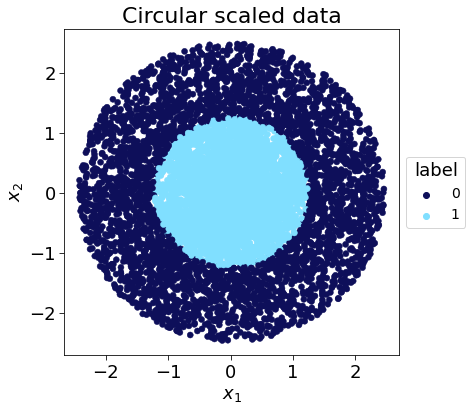

In [195]:
# number of data
N = 8000
# box dim
B = 100

x, y = create_data.create_data(N, B, c='rad')
# re-scaling data 
mean = np.mean(x, axis=0)
std = np.std(x, axis=0)
x_scaled = preprocess.standardize(x, mean, std)

# plotting data
fig = plt.figure( figsize=(6,6) )
ax  = plot_utils.plot_labeled_data( x_scaled, y,
                                    fig, title='Circular scaled data')
plt.show()

#### 4.1.b) Dividing data
Here we divide data in test, validation and training sets such that they are disjoint sets

In [196]:
train_frac = 0.7                   # fraction of original data used for training and validation (other for test)
valid_frac = 0.3                   # fraction of previous data used for validation (other for training)

N_train = int(N*train_frac)
N_valid = int(N_train*valid_frac)
circ_test  = (np.copy(x_scaled[N_train:]),       np.copy(y[N_train:]))
circ_train = (np.copy(x_scaled[N_valid:N_train]),np.copy(y[N_valid:N_train]))
circ_valid = (np.copy(x_scaled[0:N_valid]),      np.copy(y[0:N_valid]))

print(f"\nN_train :\t{circ_train[0].shape[0]} \nN_valid :\t{circ_valid[0].shape[0]} \
        \nN_test  :\t{circ_test[0].shape[0]}")


N_train :	3920 
N_valid :	1680         
N_test  :	2400


#### 4.1.c) Training best DNN
Now we train the best model paying attention to the dimensionality of the input

In [209]:
print(networks[0].summary())
fit1 = networks[0].fit(
       circ_train[0], circ_train[1],
       epochs          = N_epochs,
       batch_size      = minibatch,
       validation_data = circ_valid,
       verbose         = 0 )

Model: "circular data neural network"
____________________________________________________________________________________________________
 Layer (type)                                Output Shape                            Param #        
 input_layer (InputLayer)                    [(None, 2)]                             0              
                                                                                                    
 hidden_0 (Dense)                            (None, 20)                              60             
                                                                                                    
 dropout_0 (Dropout)                         (None, 20)                              0              
                                                                                                    
 hidden_1 (Dense)                            (None, 20)                              420            
                                                     

#### 4.1.d) Results

ValueError: x and y must have same first dimension, but have shapes (250,) and (1,)

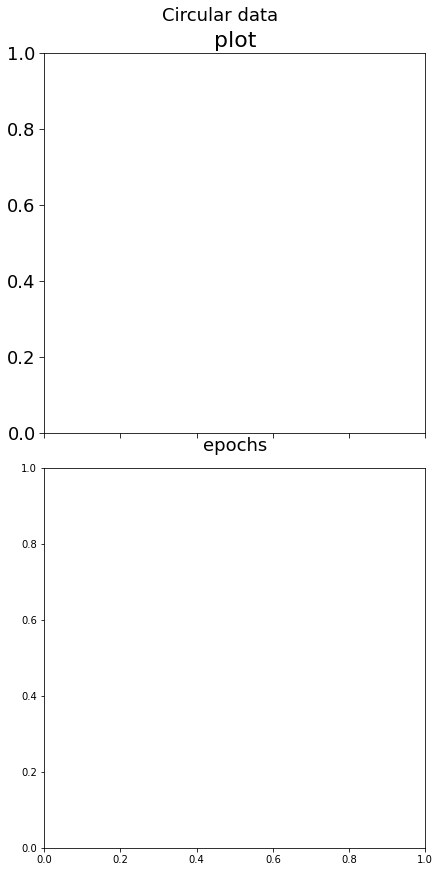

In [221]:
fig, ax = plt.subplots( 2, 1, figsize=(6, 12), sharex=True, constrained_layout=True )
fig.suptitle( 'Circular data', fontsize=18)

# plotting loss
plot_utils.plot_loss(
           epochs = N_epochs,
           loss   = fit1.history['loss'],
           fig    = fig,
           ax     = ax[0],
           label  = 'train',
           color  = "#009cff" )
plot_utils.plot_loss(
           epochs = N_epochs,
           loss   = fit1.history['val_loss'],
           fig    = fig,
           ax     = ax[0],
           label  = 'validation',
           color  = "#ff6300",
           loss_label = 'Loss',
           title  = None )

# plotting accuracy
plot_utils.plot_metric(
           epochs = N_epochs,
           metric = fit1.history['accuracy'],
           fig    = fig,
           ax     = ax[1],
           label  = 'train',
           color  = "#009cff",
           title  = None )
plot_utils.plot_metric(
           epochs = N_epochs,
           metric = fit1.history['val_accuracy'],
           fig    = fig,
           ax     = ax[1],
           label  = 'validation',
           color  = "#ff6300",
           metric_label = 'Accuracy',
           title  = None )
    
plt.show()

In [149]:
test = model_gridsearch.evaluate(
    circ_test[0], circ_test[1],
    batch_size      = model_gridsearch.get_params()['batch_size'],
    verbose         = 0,
)

print("test loss, test acc:", test)

AttributeError: 'KerasClassifier' object has no attribute 'evaluate'

In [148]:
model_gridsearch.get_params()

{'n_features': 2,
 'epochs': 250,
 'batch_size': 50,
 'build_fn': <function __main__.create_model(n_features, neurons=[20, 20, 1], dropout_arc=[1], dropout_rates=[0.2], hidden_activation='relu', batch_norm_arc=None, output_activation='sigmoid', name='my lovely neural network', loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])>}

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=452e6836-b7b8-455e-80d9-d4109b6baddf' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>